# Function

In [1]:
def MakeDataFrame(data, list_of_column):
    df = pd.DataFrame(data, columns = list_of_column) 
    return df

def ConcatDataFrame(data1, data2):
    data_full = pd.concat([data1, data2], axis=1, sort=False)
    return data_full

def CheckRollingMean(dataset, input_window=12):
    rolMean = dataset.rolling(window=input_window).mean() # window = 12 karena data bulanan
    rolStd = dataset.rolling(window=input_window).std()
    print('Rolling Mean: ', rolMean)
    print('Rolling STD: ', rolStd)

from statsmodels.tsa.stattools import adfuller
def TestStationarity(dataset):
    
    # Determining rolling statistics
    movingAverage = dataset.rolling(window=12).mean()
    movingSTD = dataset.rolling(window=12).std()
        
    # Plot rolling statistics
    orig = plt.plot(dataset, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller Test
    print('Result of Dickey-Fuller Test')
    dftest = adfuller(dataset['Price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p=value', 'Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key] = value
    print(dfoutput)

from statsmodels.tsa.seasonal import seasonal_decompose
def SeasonalDecompose(dataset, input_freq=None):
    decomposed = seasonal_decompose(dataset, freq=input_freq)

    trend = decomposed.trend
    seasonal = decomposed.seasonal
    residual = decomposed.resid

    plt.subplot(411)
    plt.plot(dataset, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    return decomposed
    
from statsmodels.tsa.stattools import acf, pacf
def Plot_ACF_PACF(dataset):
    # ACF and PACF plot
    ACF = acf(dataset, nlags=20)
    PACF = pacf(dataset, nlags=20, method='ols')

    # plot ACF
    plt.subplot(121)
    plt.plot(ACF)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.title("AutoCorrelation Function")

    # plot PACF
    plt.subplot(122)
    plt.plot(PACF)
    plt.axhline(y=0, linestyle='--', color='grey')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)), linestyle='--', color='gray')
    plt.title("Partial AutoCorrelation Function")

    plt.tight_layout()

def train_test_builder(dataset, size_test=0.3):
    test_count = int(len(dataset)*size_test)
    train_count = len(dataset)-test_count
    
    train = dataset[:train_count]
    test = dataset[train_count:]
    
    return train, test

from statsmodels.tsa.arima_model import ARIMA
def StepForwardARIMA(input_order, data_train, data_test):
    history = data_train
    predictions = list()
    
    for t in range(len(data_test)):
        model = ARIMA(history, order=input_order)
        model_fit = model.fit()
        pred = model_fit.forecast()
        pred = pred[0]
        obs = data_test[t:t+1]
        history = pd.concat([history, obs])
        predictions.append(pred)
    
    predictions_df = MakeDataFrame(predictions, ['Price'])
    index = data_test.index
    indexed_predictions = predictions_df.set_index(index)
    
    return indexed_predictions
    
def PlotPredictARIMA(input_order, data_train):
    start = input_order[1]
    end = len(data_train)
    model = ARIMA(data_train, order=input_order)
    model_fit = model.fit()
    model_fit.plot_predict(start=start, end=end)

def ComparePredictions(predictions, data_test):
    print('-------------------- Compare Predictions --------------------')
    for t in range(len(data_test)):
        pred = predictions.iloc[t][0]
        obs = data_test.iloc[t][0]
        print('predicted: ', pred, ', expected: ', obs, ', error: ', abs(pred-obs))
    print('-------------------------------------------------------------')
        
        
def MAPE(predictions, data_test):
    temp = list()
    
    for t in range(len(predictions)):
        var = abs((data_test.iloc[t][0]-predictions.iloc[t][0])/data_test.iloc[t][0])
        temp.append(var)

    mape = 100*(1/len(predictions)*sum(temp))
    
    return mape

def EvaluateParametersARIMA(data_train, data_test, p_values, d_values, q_values):
    data_test_log = np.log(data_test)
    best_score, best_cfg = float("inf"), 0
    count = 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                count += 1
                try:
                    predictions = StepForwardARIMA(order, data_train, data_test_log)
                    predictions_original_value = np.exp(predictions)
                    mse = mean_squared_error(data_test, predictions_original_value)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('(', count, ')', ' ARIMA', order, 'MSE=', mse)
                except:
                    print('(', count, ')')
                    continue
                    
    print('Best ARIMA', best_cfg, 'MSE=', best_score)

from statsmodels.tsa.statespace.sarimax import SARIMAX
def StepForwardSARIMA(input_order, data_train, data_test):
    order, sorder, trend = input_order
    history = data_train
    predictions = list()
    
    for t in range(len(data_test)):
        model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        pred = model_fit.forecast()
        pred = pred.values[0]
        obs = data_test[t:t+1]
        history = pd.concat([history, obs])
        predictions.append(pred)
        
    predictions_df = MakeDataFrame(predictions, ['Price'])
    index = data_test.index
    indexed_predictions = predictions_df.set_index(index)
    
    return indexed_predictions

# belum direfactor
def EvaluateParametersSARIMA(data_train, data_test):
    p_values = [0, 1, 2]
    q_values = [0, 1]
    d_values = [0, 1, 2]
    t_values = ['n', 'c', 't', 'ct']
    P_values = [0, 1, 2]
    D_values = [0, 1]
    Q_values = [0, 1, 2]
    m_values = [0, 4, 12]
    
    count = 0
    data_test_log = np.log(data_test)
    best_score, best_cfg = float("inf"), 0
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for t in t_values:
                    for P in P_values:
                        for D in D_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order = [(p,d,q), (P,D,Q,m), t]
                                    count += 1
                                    try:
                                        predictions = StepForwardSARIMA(order, data_train, data_test_log)
                                        predictions_original_value = np.exp(predictions)
                                        mse = mean_squared_error(data_test, predictions_original_value)
                                        if mse < best_score:
                                            best_score, best_cfg = mse, order
                                        print('(', count, ') SARIMA', order, 'MSE=', mse)
                                    except:
                                        print('(', count, ')')
                                        continue
    print('Best SARIMA', best_cfg, 'MSE=', best_score)
    
def RSS(fitted_values, train_data):
    train_diff = train_data.diff()
    train_diff.dropna(inplace=True)
    print('sum of squares of residuals (RSS) : %f' %sum((fitted_values - train_diff['Price'])**2))
    
def EvaluateKNNRegressor(n_values, p_values, weight_values, X_train, y_train, X_test, y_test):
    n_best = -1
    p_best = -1
    weight_best = '-'
    mse_best = float('inf')
    
    for n in n_values:
        for p in p_values:
            for weight in weight_values:
                try:
                    KNN = KNeighborsRegressor(n_neighbors=n)
                    KNN.fit(X_train, y_train)
                    pred = KNN.predict(X_test)
                    mse = mean_squared_error(y_test, pred)
                    if mse < mse_best:
                        mse_best = mse
                        n_best = n
                        p_best = p
                        weight_best = weight
                    print('n:', n, 'p:', p, 'weight:', weight, 'mse:', mse)
                except:
                    print('n:', n, 'p:', p, 'weight:', weight)
                    continue
        
    print('Best --> n:', n_best,'p:', p_best, 'weight:', weight_best, 'mse:', mse_best)
    

# Data Bulanan (WFP)

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

plt.style.use('fivethirtyeight') 
rcParams['figure.figsize'] = 10,6

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [3]:
colNames = ['date', 'cmname', 'unit', 'category', 'price']
dataset = pd.read_csv("indonesia-food-prices-1.csv", usecols=colNames)
dataset_wfp = pd.read_csv("wfp_food_prices_indonesia (2).csv", usecols=colNames)

#dataset_wfp = pd.read_csv("wfp_food_prices_indonesia (2).csv")

dataset_wfp.head()

,date,cmname,unit,category,price
0,#date,#item+name,#item+unit,#item+type,#value
1,2007-01-15,Rice - Retail,KG,cereals and tubers,5941.9752
2,2007-02-15,Rice - Retail,KG,cereals and tubers,6445.0
3,2007-03-15,Rice - Retail,KG,cereals and tubers,6414.0
4,2007-04-15,Rice - Retail,KG,cereals and tubers,6083.0


In [5]:
colNames2 = ['date', 'cmname', 'price']
dataset_wfp2 = pd.read_csv("wfp_food_prices_indonesia (2).csv", usecols=colNames2)

dataset_wfp2.head()

,date,cmname,price
0,#date,#item+name,#value
1,2007-01-15,Rice - Retail,5941.9752
2,2007-02-15,Rice - Retail,6445.0
3,2007-03-15,Rice - Retail,6414.0
4,2007-04-15,Rice - Retail,6083.0


In [6]:
unique = []
for i in dataset_wfp.cmname:
    if i not in unique:
        unique.append(i)
        
unique

['#item+name',
 'Rice - Retail',
 'Wheat flour - Retail',
 'Meat (chicken, broiler) - Retail',
 'Chili (red) - Retail',
 'Eggs - Retail',
 'Milk (condensed) - Retail',
 'Oil (vegetable) - Retail',
 'Sugar - Retail',
 'Meat (beef) - Retail',
 'Fuel (kerosene) - Retail',
 'Chili (birdâ€™s eye)   - Retail']

In [9]:
rice_count = 0
wheat_count = 0
chicken_count = 0
chiliGreen_count = 0
chiliRed_count = 0
egg_count = 0
milk_count = 0
oilVegetable_count = 0
sugar_count = 0
beef_count = 0
fuelKerosine_count = 0
else_count = 0

rice = []
wheat = []
chicken = []
chili_red = []
chili_birdseye = []
egg = []
milk = []
veg_oil = []
sugar = []
meat = []

rice_date = []
wheat_date = []
chicken_date = []
chili_red_date = []
chili_birdseye_date = []
egg_date = []
milk_date = []
veg_oil_date = []
sugar_date = []
meat_date = []

for i in range(1, len(dataset_wfp)):
    if dataset_wfp.iloc[i][1] == "Rice - Retail":
        rice.append(dataset_wfp.iloc[i][4])
        rice_count += 1
        rice_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Wheat flour - Retail":
        wheat.append(dataset_wfp.iloc[i][4])
        wheat_count += 1
        wheat_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Meat (chicken, broiler) - Retail":
        chicken.append(dataset_wfp.iloc[i][4])
        chicken_count += 1
        chicken_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Chili (birdâ€™s eye)   - Retail":
        chili_birdseye.append(dataset_wfp.iloc[i][4])
        chiliGreen_count += 1
        chili_birdseye_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Chili (red) - Retail":
        chili_red.append(dataset_wfp.iloc[i][4])
        chiliRed_count += 1
        chili_red_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Eggs - Retail":
        egg.append(dataset_wfp.iloc[i][4])
        egg_count += 1
        egg_date.append(dataset_wfp.iloc[i][0])
        
        if dataset_wfp.iloc[i][0] == "2013-03-15": #instance yang null ditambahkan manual
            egg.append(None)
            egg_count += 1
            egg_date.append("2013-04-15")
        #print(dataset_wfp.iloc[i][0], "instance: ", len(egg_date))
    elif dataset_wfp.iloc[i][1] == "Milk (condensed) - Retail":
        milk.append(dataset_wfp.iloc[i][4])
        milk_count += 1
        milk_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Oil (vegetable) - Retail":
        veg_oil.append(dataset_wfp.iloc[i][4])
        oilVegetable_count += 1
        veg_oil_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Sugar - Retail":
        sugar.append(dataset_wfp.iloc[i][4])
        sugar_count += 1
        sugar_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Meat (beef) - Retail":
        meat.append(dataset_wfp.iloc[i][4])
        beef_count += 1
        meat_date.append(dataset_wfp.iloc[i][0])
    elif dataset_wfp.iloc[i][1] == "Fuel (kerosene) - Retail":
        fuelKerosine_count += 1
    else:
        else_count += 1
        
print("rice_count: ", rice_count, len(rice))
print("wheat_count: ", wheat_count, len(wheat))
print("chicken_count: ", chicken_count, len(chicken))
print("chiligreen_count: ", chiliGreen_count, len(chili_birdseye))
print("chilired_count: ", chiliRed_count, len(chili_red))
print("egg_count: ", egg_count, len(egg))
print("milk_count: ", milk_count, len(milk))
print("vegetableoil_count: ", oilVegetable_count, len(veg_oil))
print("sugar_count: ", sugar_count, len(sugar))
print("beef_count: ", beef_count, len(meat))
print("kerosine_count: ", fuelKerosine_count)
print("else_count: ", else_count)


rice_count:  147 147
wheat_count:  147 147
chicken_count:  147 147
chiligreen_count:  147 147
chilired_count:  147 147
egg_count:  147 147
milk_count:  147 147
vegetableoil_count:  147 147
sugar_count:  147 147
beef_count:  147 147
kerosine_count:  84
else_count:  0


In [8]:
print(np.setdiff1d(rice_date, egg_date))

['2013-04-15']


In [10]:
print(len(dataset))
print(len(dataset_wfp))

1394
1554


In [11]:
print(np.setdiff1d(rice_date, egg_date))

[]


In [12]:
X_rice = MakeDataFrame(rice, ["Price"])
X_rice_date = MakeDataFrame(rice_date, ["Date"])
X_wheat = MakeDataFrame(wheat, ["Price"])
X_wheat_date = MakeDataFrame(wheat_date, ["Date"])
X_chicken = MakeDataFrame(chicken, ["Price"])
X_chicken_date = MakeDataFrame(chicken_date, ["Date"])
X_chili_red = MakeDataFrame(chili_red, ["Price"])
X_chili_red_date = MakeDataFrame(chili_red_date, ["Date"])
X_chili_birdseye = MakeDataFrame(chili_birdseye, ["Price"])
X_chili_birdseye_date = MakeDataFrame(chili_birdseye_date, ["Date"])
X_egg = MakeDataFrame(egg, ["Price"])
X_egg_date = MakeDataFrame(egg_date, ["Date"])
X_milk = MakeDataFrame(milk, ["Price"])
X_milk_date = MakeDataFrame(milk_date, ["Date"])
X_veg_oil = MakeDataFrame(veg_oil, ["Price"])
X_veg_oil_date = MakeDataFrame(veg_oil_date, ["Date"])
X_sugar = MakeDataFrame(sugar, ["Price"])
X_sugar_date = MakeDataFrame(sugar_date, ["Date"])
X_meat = MakeDataFrame(meat, ["Price"])
X_meat_date = MakeDataFrame(meat_date, ["Date"])

In [13]:
#for i in range(len(egg_date)):
#    print(egg_date[i], egg[i])

In [14]:
print(len(egg), len(egg_date))

147 147


In [15]:
# Concat DataFrame Date and Price
X_rice_full = ConcatDataFrame(X_rice_date, X_rice)
X_wheat_full = ConcatDataFrame(X_wheat_date, X_wheat)
X_chicken_full = ConcatDataFrame(X_chicken_date, X_chicken)
X_chili_red_full = ConcatDataFrame(X_chili_red, X_chili_red_date)
X_chili_birdseye_full = ConcatDataFrame(X_chili_birdseye, X_chili_birdseye_date)
X_egg_full = ConcatDataFrame(X_egg_date, X_egg)
X_milk_full = ConcatDataFrame(X_milk_date, X_milk)
X_veg_oil_full = ConcatDataFrame(X_veg_oil_date, X_veg_oil)
X_sugar_full = ConcatDataFrame(X_sugar_date, X_sugar)
X_meat_full = ConcatDataFrame(X_meat_date, X_meat)

# Convert type to Date and Set Date as Index
X_rice_full['Date'] = pd.to_datetime(X_rice_full['Date'], infer_datetime_format=True)
X_rice_full = X_rice_full.set_index(['Date'])
X_wheat_full['Date'] = pd.to_datetime(X_wheat_full['Date'], infer_datetime_format=True)
X_wheat_full = X_wheat_full.set_index(['Date'])
X_chicken_full['Date'] = pd.to_datetime(X_chicken_full['Date'], infer_datetime_format=True)
X_chicken_full = X_chicken_full.set_index(['Date'])
X_chili_red_full['Date'] = pd.to_datetime(X_chili_red_full['Date'], infer_datetime_format=True)
X_chili_red_full = X_chili_red_full.set_index(['Date'])
X_chili_birdseye_full['Date'] = pd.to_datetime(X_chili_birdseye_full['Date'], infer_datetime_format=True)
X_chili_birdseye_full = X_chili_birdseye_full.set_index(['Date'])
X_egg_full['Date'] = pd.to_datetime(X_egg_full['Date'], infer_datetime_format=True)
X_egg_full = X_egg_full.set_index(['Date'])
X_milk_full['Date'] = pd.to_datetime(X_milk_full['Date'], infer_datetime_format=True)
X_milk_full = X_milk_full.set_index(['Date'])
X_veg_oil_full['Date'] = pd.to_datetime(X_veg_oil_full['Date'], infer_datetime_format=True)
X_veg_oil_full = X_veg_oil_full.set_index(['Date'])
X_sugar_full['Date'] = pd.to_datetime(X_sugar_full['Date'], infer_datetime_format=True)
X_sugar_full = X_sugar_full.set_index(['Date'])
X_meat_full['Date'] = pd.to_datetime(X_meat_full['Date'], infer_datetime_format=True)
X_meat_full = X_meat_full.set_index(['Date'])

#X_chili_red_full.tail()

In [18]:
#X_egg_full.isnull().sum()
#X_egg_full.info()
X_egg_full.head(8)
#X_egg_full.tail()
X_chicken_full.head(8)

,Price
Date,
2007-01-15,20122.7989
2007-02-15,18760.0
2007-03-15,20323.0
2007-04-15,22796.0
2007-05-15,22659.0
2007-06-15,22403.0
2007-07-15,24370.0
2007-08-15,24615.0


In [13]:
#print(len(X_egg_full))
X_egg_full = X_egg_full.iloc[0:]
X_egg_full = X_egg_full.fillna(method='ffill') # fill null dengan value instance sebelumnya
X_egg_full.head()
#print(len(X_egg_full))
#X_egg_full.info()

,Price
Date,
2007-01-15,9150.7401
2007-02-15,8486.441
2007-03-15,7993.549
2007-04-15,8732.9076
2007-05-15,9106.7251


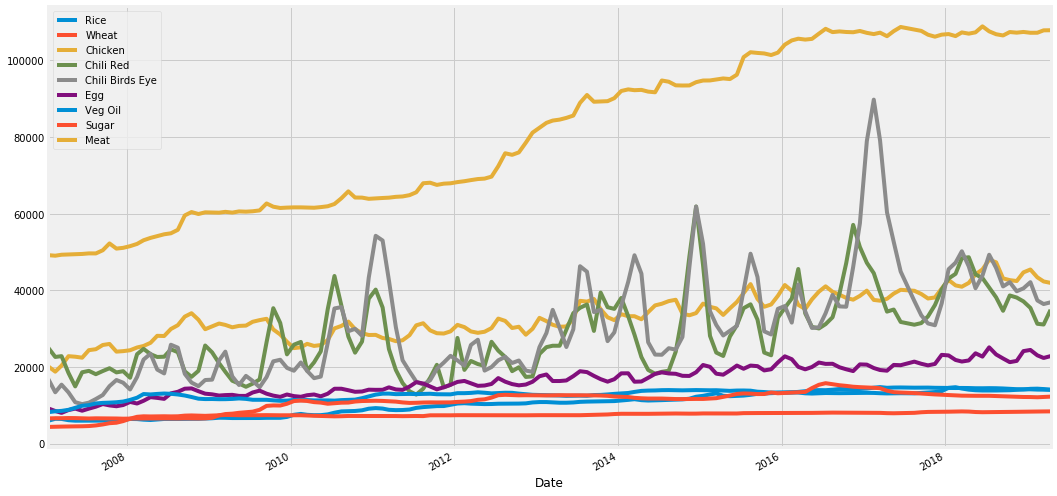

In [14]:
# Convert column Price type to float biar bisa di-plot
X_rice_full['Price'] = X_rice_full['Price'].astype(float)
X_wheat_full['Price'] = X_wheat_full['Price'].astype(float)
X_chicken_full['Price'] = X_chicken_full['Price'].astype(float)
X_chili_red_full['Price'] = X_chili_red_full['Price'].astype(float)
X_chili_birdseye_full['Price'] = X_chili_birdseye_full['Price'].astype(float)
X_egg_full['Price'] = X_egg_full['Price'].astype(float)
X_milk_full['Price'] = X_milk_full['Price'].astype(float)
X_veg_oil_full['Price'] = X_veg_oil_full['Price'].astype(float)
X_sugar_full['Price'] = X_sugar_full['Price'].astype(float)
X_meat_full['Price'] = X_meat_full['Price'].astype(float)

plt.figure(figsize=[16,9])
X_rice_full['Price'].plot()
X_wheat_full['Price'].plot()
X_chicken_full['Price'].plot()
X_chili_red_full['Price'].plot()
X_chili_birdseye_full['Price'].plot()
X_egg_full['Price'].plot()
X_veg_oil_full['Price'].plot()
X_sugar_full['Price'].plot()
X_meat_full['Price'].plot()

plt.legend(['Rice', 'Wheat', 'Chicken', 'Chili Red', 'Chili Birds Eye', 'Egg', 'Veg Oil', 'Sugar', 'Meat'])
plt.show()

Plot Price


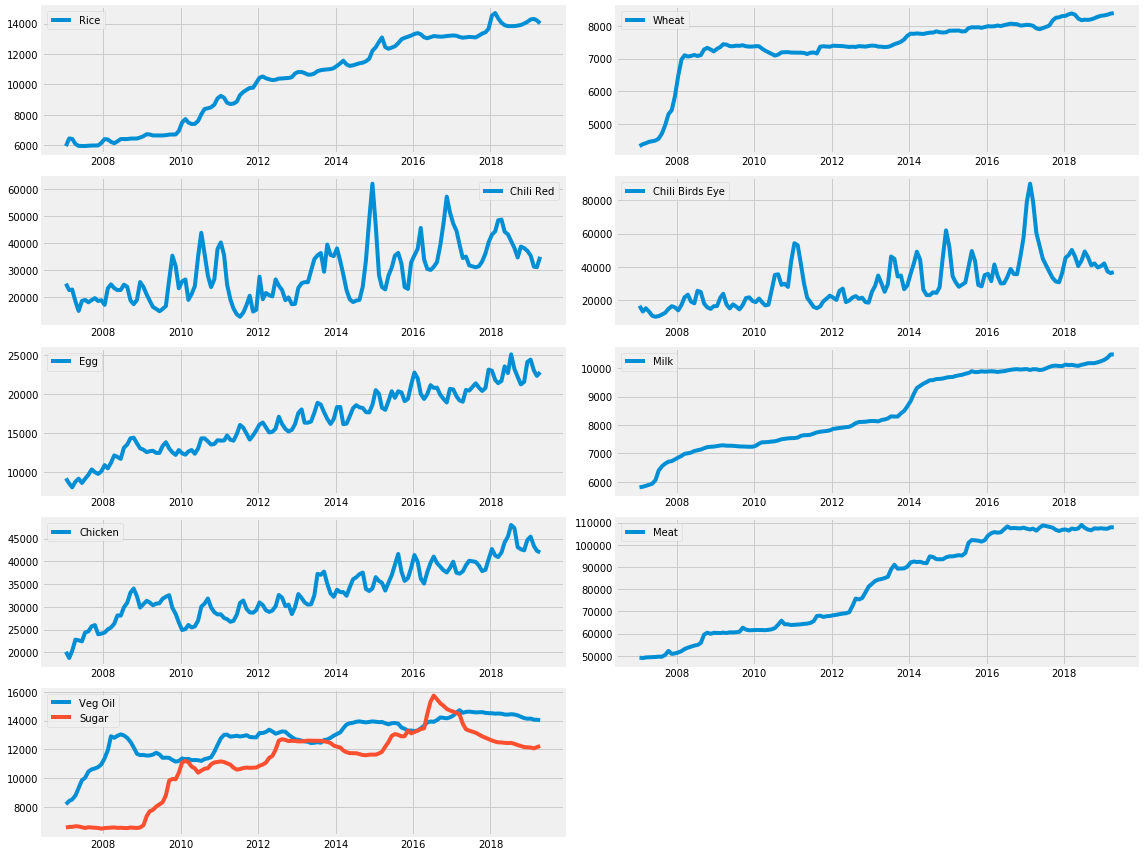

In [15]:
plt.figure(figsize=[16,12])
plt.subplot(521)
plt.plot(X_rice_full, label='Rice')
plt.legend(loc='best')
plt.subplot(522)
plt.plot(X_wheat_full, label='Wheat')
plt.legend(loc='best')
plt.subplot(523)
plt.plot(X_chili_red_full, label='Chili Red')
plt.legend(loc='best')
plt.subplot(524)
plt.plot(X_chili_birdseye_full, label='Chili Birds Eye')
plt.legend(loc='best')
plt.subplot(525)
plt.plot(X_egg_full, label='Egg')
plt.legend(loc='best')
plt.subplot(526)
plt.plot(X_milk_full, label='Milk')
plt.legend(loc='best')
plt.subplot(527)
plt.plot(X_chicken_full, label='Chicken')
plt.legend(loc='best')
plt.subplot(528)
plt.plot(X_meat_full, label='Meat')
plt.legend(loc='best')
plt.subplot(529)
plt.plot(X_veg_oil_full, label='Veg Oil')
plt.legend(loc='best')
plt.subplot(529)
plt.plot(X_sugar_full, label='Sugar')
plt.legend(loc='best')
plt.tight_layout()
print('Plot Price')

In [16]:
X_chicken_full.head(10)

,Price
Date,
2007-01-15,20122.7989
2007-02-15,18760.0000
2007-03-15,20323.0000
2007-04-15,22796.0000
2007-05-15,22659.0000
2007-06-15,22403.0000
2007-07-15,24370.0000
2007-08-15,24615.0000
2007-09-15,25716.0000


In [17]:
chicken_dateindex = X_chicken_full
chicken_dateindex = np.log(chicken_dateindex)
chicken_dateindex.head()

,Price
Date,
2007-01-15,9.909609
2007-02-15,9.839482
2007-03-15,9.919509
2007-04-15,10.034340
2007-05-15,10.028312


## Preprocessing 

In [18]:
rcParams['figure.figsize'] = 10,6

In [19]:
chicken_train, chicken_test = train_test_builder(X_chicken_full, size_test=0.2)
print('train: ', len(chicken_train),',', 'test: ', len(chicken_test))
chicken_train.head(10)

train:  118 , test:  29


,Price
Date,
2007-01-15,20122.7989
2007-02-15,18760.0000
2007-03-15,20323.0000
2007-04-15,22796.0000
2007-05-15,22659.0000
2007-06-15,22403.0000
2007-07-15,24370.0000
2007-08-15,24615.0000
2007-09-15,25716.0000


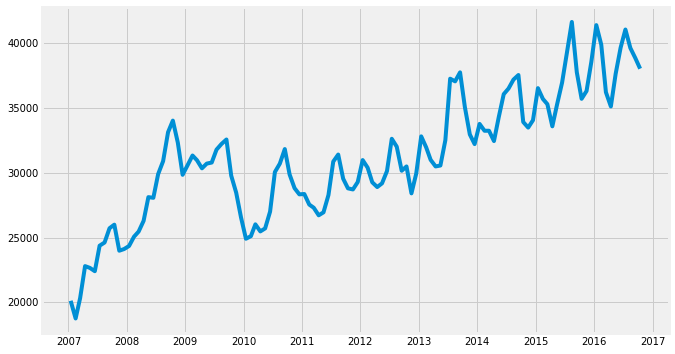

In [20]:
plt.plot(chicken_train)

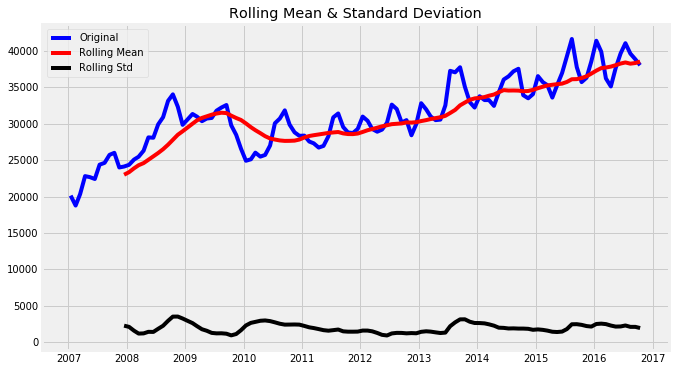

Result of Dickey-Fuller Test
Test Statistic                 -0.897860
p=value                         0.788676
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [21]:
TestStationarity(chicken_train)

## Transform

Result of Dickey-Fuller Test
Test Statistic                 -1.220064
p=value                         0.664905
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


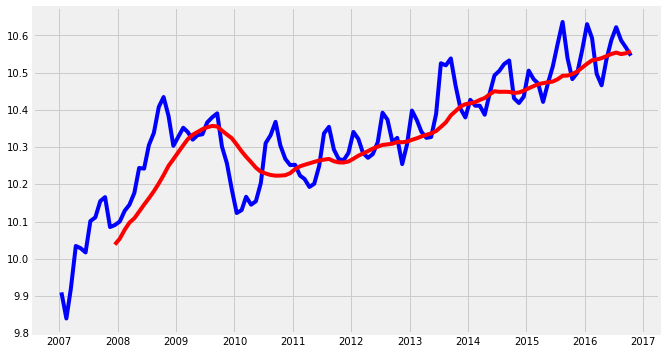

In [22]:
# Log Scale
chicken_logScale = np.log(chicken_train)

# Test Stationary
movingAverage_chicken = chicken_logScale.rolling(window=12).mean()
movingStd_chicken = chicken_logScale.rolling(window=12).std()

plt.plot(chicken_logScale, color='blue')
plt.plot(movingAverage_chicken, color='red')
#plt.plot(movingStd_chicken, color='black')

# Dickey-Fuller Test
print('Result of Dickey-Fuller Test')
dftest = adfuller(chicken_logScale['Price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p=value', 'Lags Used', 'Number of Observation Used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key] = value
print(dfoutput)

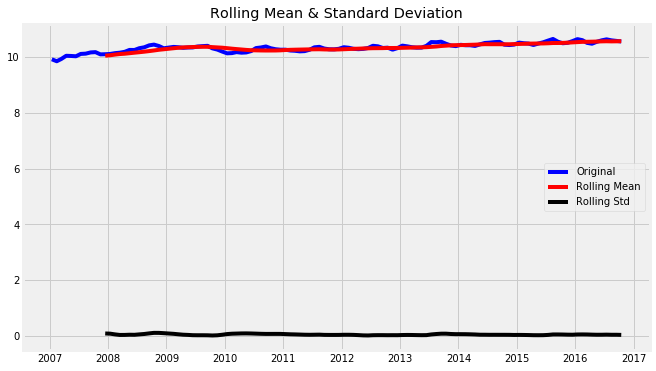

Result of Dickey-Fuller Test
Test Statistic                 -1.220064
p=value                         0.664905
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [23]:
TestStationarity(chicken_logScale)

In [24]:
# Moving Average
#chicken_log_moving_avg_diff = chicken_logScale - movingAverage_chicken
#chicken_log_moving_avg_diff.dropna(inplace=True)

#TestStationarity(chicken_log_moving_avg_diff)

In [25]:
# Weighted Average
#chicken_weighted_avg = chicken_logScale.ewm(halflife=12, min_periods=0,
#                                           adjust=True).mean()
#plt.figure()
#plt.title('Weighted Average')
#plt.plot(chicken_weighted_avg)

#plt.figure()
#chicken_log_weighted_mean = chicken_logScale - chicken_weighted_avg
#TestStationarity(chicken_log_weighted_mean)

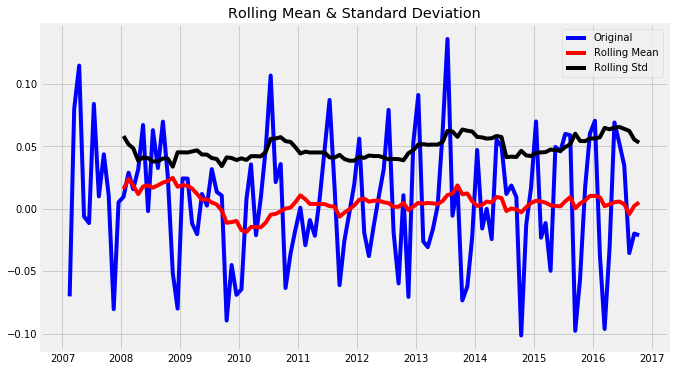

Result of Dickey-Fuller Test
Test Statistic                 -2.693662
p=value                         0.075141
Lags Used                      11.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


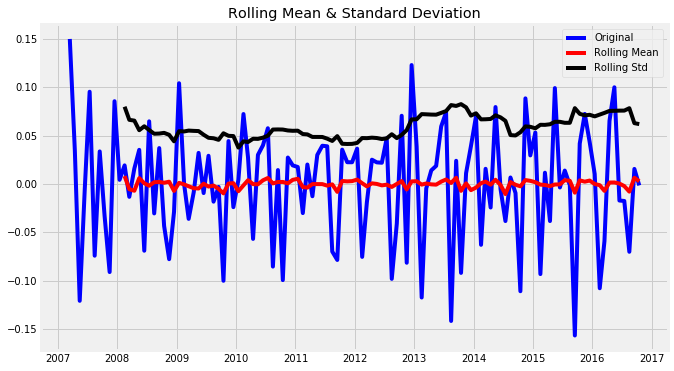

Result of Dickey-Fuller Test
Test Statistic                 -4.185817
p=value                         0.000696
Lags Used                      13.000000
Number of Observation Used    102.000000
critical value (1%)            -3.496149
critical value (5%)            -2.890321
critical value (10%)           -2.582122
dtype: float64


In [26]:
# Differencing
chicken_log_diff = chicken_logScale.diff()
chicken_log_diff.dropna(inplace=True)

chicken_log_diff_2 = chicken_log_diff.diff()
chicken_log_diff_2.dropna(inplace=True)

TestStationarity(chicken_log_diff)
TestStationarity(chicken_log_diff_2)

Test Stationarity of Residual


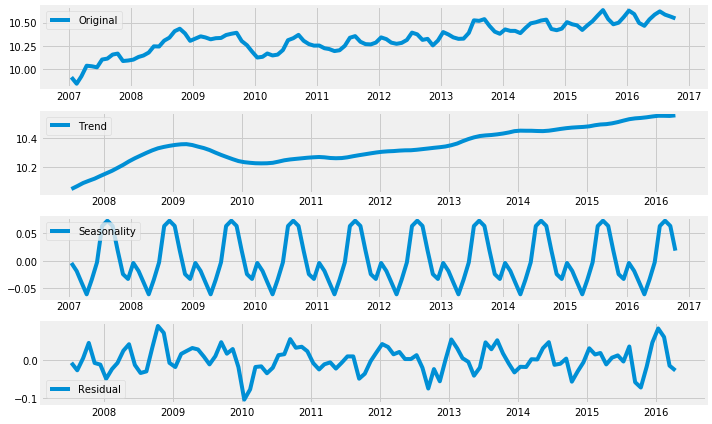

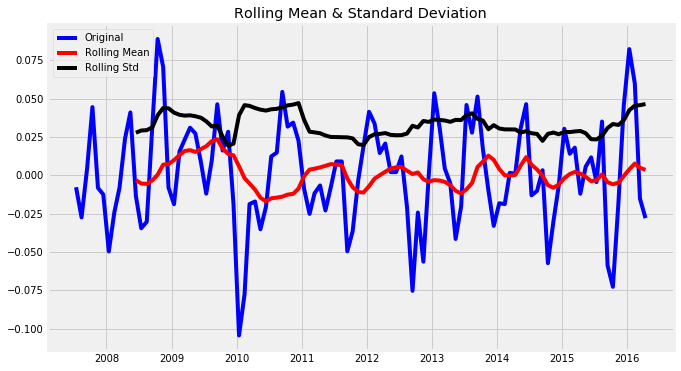

Result of Dickey-Fuller Test
Test Statistic               -7.621326e+00
p=value                       2.124632e-11
Lags Used                     1.000000e+00
Number of Observation Used    1.040000e+02
critical value (1%)          -3.494850e+00
critical value (5%)          -2.889758e+00
critical value (10%)         -2.581822e+00
dtype: float64


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_chicken = SeasonalDecompose(chicken_logScale, input_freq=12)
residual_chicken = decomposed_chicken.resid
residual_chicken.dropna(inplace=True)

plt.figure()
print("Test Stationarity of Residual")
TestStationarity(residual_chicken)

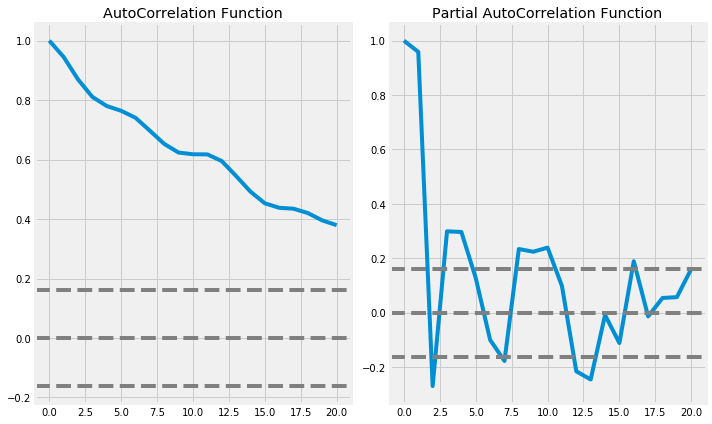

In [28]:
Plot_ACF_PACF(X_chicken_full)

## Model Chicken

In [28]:
train_chicken = np.log(chicken_train)
train_chicken_diff = train_chicken.diff()
train_chicken_diff.dropna(inplace=True)
test_chicken = chicken_test
test_chicken_log = np.log(test_chicken)

In [166]:
p_values = [0, 1, 2, 3, 4, 6, 8, 10]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
warnings.filterwarnings("ignore")

EvaluateParametersARIMA(train_chicken, test_chicken, p_values, d_values, q_values)

( 1 )  ARIMA (0, 0, 0) MSE= 102657611.45776401
( 2 )  ARIMA (0, 0, 1) MSE= 35388358.45440713
( 3 )
( 4 )  ARIMA (0, 1, 0) MSE= 2448697.462257263
( 5 )  ARIMA (0, 1, 1) MSE= 2169752.523320764
( 6 )  ARIMA (0, 1, 2) MSE= 2134172.839659312
( 7 )  ARIMA (0, 2, 0) MSE= 3674890.2341478416
( 8 )  ARIMA (0, 2, 1) MSE= 2503661.363054519
( 9 )  ARIMA (0, 2, 2) MSE= 2207268.1678450108
( 10 )  ARIMA (1, 0, 0) MSE= 2537290.282795848
( 11 )  ARIMA (1, 0, 1) MSE= 2296153.181054154
( 12 )  ARIMA (1, 0, 2) MSE= 2317782.758261521
( 13 )  ARIMA (1, 1, 0) MSE= 2308308.1341835256
( 14 )  ARIMA (1, 1, 1) MSE= 2161993.2993657133
( 15 )  ARIMA (1, 1, 2) MSE= 1824555.956314484
( 16 )  ARIMA (1, 2, 0) MSE= 3697831.480431568
( 17 )
( 18 )
( 19 )  ARIMA (2, 0, 0) MSE= 2468647.378485576
( 20 )  ARIMA (2, 0, 1) MSE= 2303187.031864054
( 21 )  ARIMA (2, 0, 2) MSE= 2435745.8236460756
( 22 )  ARIMA (2, 1, 0) MSE= 1925262.1802478032
( 23 )  ARIMA (2, 1, 1) MSE= 1822041.7833605898
( 24 )  ARIMA (2, 1, 2) MSE= 1309483.248

## ARIMA (3, 1, 2)

In [29]:
chicken_ARIMA = StepForwardARIMA([3, 1, 2], train_chicken, test_chicken_log)

In [30]:
predictions_chicken_ARIMA_original_value = np.exp(chicken_ARIMA)
predictions_chicken_ARIMA_original_value.head(10)

,Price
Date,
2016-11-15,38908.048138
2016-12-15,39188.770697
2017-01-15,39453.757755
2017-02-15,39346.980435
2017-03-15,35915.229890
2017-04-15,36908.086647
2017-05-15,39061.042526
2017-06-15,40979.836115
2017-08-15,40704.235460


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ComparePredictions(predictions_chicken_ARIMA_original_value, test_chicken)

mse_ARIMA_chicken = mean_squared_error(test_chicken, predictions_chicken_ARIMA_original_value)
mae_ARIMA_chicken = mean_absolute_error(test_chicken, predictions_chicken_ARIMA_original_value)
mape_ARIMA_chicken = MAPE(predictions_chicken_ARIMA_original_value, test_chicken)

print('MSE: ', mse_ARIMA_chicken)
print('MAE: ', mae_ARIMA_chicken)
print('MAPE: ', mape_ARIMA_chicken)

-------------------- Compare Predictions --------------------
predicted:  38908.04813773335 , expected:  37547.0 , error:  1361.048137733349
predicted:  39188.770696878455 , expected:  38538.0 , error:  650.770696878455
predicted:  39453.75775457126 , expected:  39906.0 , error:  452.2422454287371
predicted:  39346.98043465386 , expected:  37480.0 , error:  1866.9804346538585
predicted:  35915.22989024129 , expected:  37285.0 , error:  1369.7701097587124
predicted:  36908.08664693744 , expected:  37777.0 , error:  868.9133530625622
predicted:  39061.04252601628 , expected:  39133.0 , error:  71.95747398371896
predicted:  40979.83611467342 , expected:  40123.0 , error:  856.8361146734169
predicted:  40704.2354604201 , expected:  39868.0 , error:  836.2354604201028
predicted:  38810.064442689894 , expected:  39031.0 , error:  220.93555731010565
predicted:  37763.94614844007 , expected:  37856.0 , error:  92.05385155993281
predicted:  37788.12690620767 , expected:  38132.0 , error:  343.8

## SARIMA 

In [32]:
chicken_SARIMA = StepForwardSARIMA([(2,1,2), (2,1,2,12), 'n'], train_chicken, test_chicken_log)

In [28]:
EvaluateParametersSARIMA(train_chicken, test_chicken)

( 1 ) SARIMA [(0, 0, 0), (0, 0, 0, 0), 'n'] MSE= 1722765322.5517242
( 2 ) SARIMA [(0, 0, 0), (0, 0, 0, 4), 'n'] MSE= 1722765322.5517242
( 3 ) SARIMA [(0, 0, 0), (0, 0, 0, 12), 'n'] MSE= 1722765322.5517242
( 4 ) SARIMA [(0, 0, 0), (0, 0, 1, 0), 'n'] MSE= 1705977386.3945289
( 5 ) SARIMA [(0, 0, 0), (0, 0, 1, 4), 'n'] MSE= 1710075102.2296243
( 6 ) SARIMA [(0, 0, 0), (0, 0, 1, 12), 'n'] MSE= 1716550470.3262498
( 7 ) SARIMA [(0, 0, 0), (0, 0, 2, 0), 'n'] MSE= 1553855696.8857212
( 8 ) SARIMA [(0, 0, 0), (0, 0, 2, 4), 'n'] MSE= 1632816208.4494686
( 9 ) SARIMA [(0, 0, 0), (0, 0, 2, 12), 'n'] MSE= 1680705205.476276
( 10 )
( 11 ) SARIMA [(0, 0, 0), (0, 1, 0, 4), 'n'] MSE= 7946355.931034523
( 12 ) SARIMA [(0, 0, 0), (0, 1, 0, 12), 'n'] MSE= 12781527.413793141
( 13 )
( 14 ) SARIMA [(0, 0, 0), (0, 1, 1, 4), 'n'] MSE= 7459295.752965934
( 15 ) SARIMA [(0, 0, 0), (0, 1, 1, 12), 'n'] MSE= 12844372.707166698
( 16 )
( 17 ) SARIMA [(0, 0, 0), (0, 1, 2, 4), 'n'] MSE= 7268063.072892116
( 18 ) SARIMA [(0, 0,

( 141 ) SARIMA [(0, 0, 0), (1, 1, 1, 12), 't'] MSE= 7539856.106965389
( 142 )
( 143 ) SARIMA [(0, 0, 0), (1, 1, 2, 4), 't'] MSE= 6618957.199907938
( 144 ) SARIMA [(0, 0, 0), (1, 1, 2, 12), 't'] MSE= 7734912.685671562
( 145 ) SARIMA [(0, 0, 0), (2, 0, 0, 0), 't'] MSE= 2390240.6901970427
( 146 ) SARIMA [(0, 0, 0), (2, 0, 0, 4), 't'] MSE= 7587674.496142201
( 147 ) SARIMA [(0, 0, 0), (2, 0, 0, 12), 't'] MSE= 6652539.484421169
( 148 ) SARIMA [(0, 0, 0), (2, 0, 1, 0), 't'] MSE= 4538509.181882733
( 149 ) SARIMA [(0, 0, 0), (2, 0, 1, 4), 't'] MSE= 8442822.154253231
( 150 ) SARIMA [(0, 0, 0), (2, 0, 1, 12), 't'] MSE= 5726481.219690398
( 151 ) SARIMA [(0, 0, 0), (2, 0, 2, 0), 't'] MSE= 2056533.1480015859
( 152 ) SARIMA [(0, 0, 0), (2, 0, 2, 4), 't'] MSE= 6366053.380996211
( 153 ) SARIMA [(0, 0, 0), (2, 0, 2, 12), 't'] MSE= 8744589.791457389
( 154 )
( 155 ) SARIMA [(0, 0, 0), (2, 1, 0, 4), 't'] MSE= 5560080.969158282
( 156 ) SARIMA [(0, 0, 0), (2, 1, 0, 12), 't'] MSE= 6536222.615703472
( 157 )
( 

( 278 ) SARIMA [(0, 0, 1), (0, 0, 2, 4), 'c'] MSE= 15652671.60282349
( 279 ) SARIMA [(0, 0, 1), (0, 0, 2, 12), 'c'] MSE= 18692347.277871143
( 280 )
( 281 ) SARIMA [(0, 0, 1), (0, 1, 0, 4), 'c'] MSE= 3548593.205319001
( 282 ) SARIMA [(0, 0, 1), (0, 1, 0, 12), 'c'] MSE= 3519285.9807179514
( 283 )
( 284 ) SARIMA [(0, 0, 1), (0, 1, 1, 4), 'c'] MSE= 2825102.1770609664
( 285 ) SARIMA [(0, 0, 1), (0, 1, 1, 12), 'c'] MSE= 3316756.413774962
( 286 )
( 287 ) SARIMA [(0, 0, 1), (0, 1, 2, 4), 'c'] MSE= 2842045.21294783
( 288 ) SARIMA [(0, 0, 1), (0, 1, 2, 12), 'c'] MSE= 3709764.3767675166
( 289 ) SARIMA [(0, 0, 1), (1, 0, 0, 0), 'c'] MSE= 2749203.381643761
( 290 ) SARIMA [(0, 0, 1), (1, 0, 0, 4), 'c'] MSE= 4250409.106514445
( 291 ) SARIMA [(0, 0, 1), (1, 0, 0, 12), 'c'] MSE= 6075418.629078594
( 292 ) SARIMA [(0, 0, 1), (1, 0, 1, 0), 'c'] MSE= 2968776.081763005
( 293 ) SARIMA [(0, 0, 1), (1, 0, 1, 4), 'c'] MSE= 4247506.069197299
( 294 ) SARIMA [(0, 0, 1), (1, 0, 1, 12), 'c'] MSE= 7141848.853084046
(

( 417 ) SARIMA [(0, 0, 1), (2, 0, 0, 12), 'ct'] MSE= 2855011.9348880197
( 418 ) SARIMA [(0, 0, 1), (2, 0, 1, 0), 'ct'] MSE= 1901320.5794109008
( 419 ) SARIMA [(0, 0, 1), (2, 0, 1, 4), 'ct'] MSE= 2179462.011623694
( 420 ) SARIMA [(0, 0, 1), (2, 0, 1, 12), 'ct'] MSE= 3014367.05207643
( 421 ) SARIMA [(0, 0, 1), (2, 0, 2, 0), 'ct'] MSE= 2961034.2366799396
( 422 ) SARIMA [(0, 0, 1), (2, 0, 2, 4), 'ct'] MSE= 2392291.4001339115
( 423 ) SARIMA [(0, 0, 1), (2, 0, 2, 12), 'ct'] MSE= 3423405.2591552534
( 424 )
( 425 ) SARIMA [(0, 0, 1), (2, 1, 0, 4), 'ct'] MSE= 2840749.57308642
( 426 ) SARIMA [(0, 0, 1), (2, 1, 0, 12), 'ct'] MSE= 4090739.3275215575
( 427 )
( 428 ) SARIMA [(0, 0, 1), (2, 1, 1, 4), 'ct'] MSE= 2808800.6255884822
( 429 ) SARIMA [(0, 0, 1), (2, 1, 1, 12), 'ct'] MSE= 4702261.071052455
( 430 )
( 431 ) SARIMA [(0, 0, 1), (2, 1, 2, 4), 'ct'] MSE= 2777067.294567951
( 432 ) SARIMA [(0, 0, 1), (2, 1, 2, 12), 'ct'] MSE= 4506502.262756903
( 433 ) SARIMA [(0, 1, 0), (0, 0, 0, 0), 'n'] MSE= 2425

( 555 ) SARIMA [(0, 1, 0), (0, 1, 1, 12), 't'] MSE= 2552966.1964709666
( 556 )
( 557 ) SARIMA [(0, 1, 0), (0, 1, 2, 4), 't'] MSE= 2867663.1442073737
( 558 ) SARIMA [(0, 1, 0), (0, 1, 2, 12), 't'] MSE= 2570926.7564913286
( 559 ) SARIMA [(0, 1, 0), (1, 0, 0, 0), 't'] MSE= 2345007.5412803264
( 560 ) SARIMA [(0, 1, 0), (1, 0, 0, 4), 't'] MSE= 2383590.3980512028
( 561 ) SARIMA [(0, 1, 0), (1, 0, 0, 12), 't'] MSE= 1853909.6055170198
( 562 ) SARIMA [(0, 1, 0), (1, 0, 1, 0), 't'] MSE= 2224136.307742416
( 563 ) SARIMA [(0, 1, 0), (1, 0, 1, 4), 't'] MSE= 2506539.358021015
( 564 ) SARIMA [(0, 1, 0), (1, 0, 1, 12), 't'] MSE= 1993286.4220048904
( 565 ) SARIMA [(0, 1, 0), (1, 0, 2, 0), 't'] MSE= 2150970.624812072
( 566 ) SARIMA [(0, 1, 0), (1, 0, 2, 4), 't'] MSE= 2078815.6080971202
( 567 ) SARIMA [(0, 1, 0), (1, 0, 2, 12), 't'] MSE= 2463848.3890033006
( 568 )
( 569 ) SARIMA [(0, 1, 0), (1, 1, 0, 4), 't'] MSE= 4873286.835597345
( 570 ) SARIMA [(0, 1, 0), (1, 1, 0, 12), 't'] MSE= 2516356.5119596287
( 

( 691 ) SARIMA [(0, 1, 1), (2, 0, 2, 0), 'n'] MSE= 1370659.5529033781
( 692 ) SARIMA [(0, 1, 1), (2, 0, 2, 4), 'n'] MSE= 1526504.8453810946
( 693 ) SARIMA [(0, 1, 1), (2, 0, 2, 12), 'n'] MSE= 1974235.5202962416
( 694 )
( 695 ) SARIMA [(0, 1, 1), (2, 1, 0, 4), 'n'] MSE= 2106334.852124285
( 696 ) SARIMA [(0, 1, 1), (2, 1, 0, 12), 'n'] MSE= 2964871.7375254515
( 697 )
( 698 ) SARIMA [(0, 1, 1), (2, 1, 1, 4), 'n'] MSE= 2177258.6056564543
( 699 ) SARIMA [(0, 1, 1), (2, 1, 1, 12), 'n'] MSE= 3130633.9723159405
( 700 )
( 701 ) SARIMA [(0, 1, 1), (2, 1, 2, 4), 'n'] MSE= 2245263.080561845
( 702 ) SARIMA [(0, 1, 1), (2, 1, 2, 12), 'n'] MSE= 3111686.535378164
( 703 ) SARIMA [(0, 1, 1), (0, 0, 0, 0), 'c'] MSE= 2170195.997022973
( 704 ) SARIMA [(0, 1, 1), (0, 0, 0, 4), 'c'] MSE= 2170195.997022973
( 705 ) SARIMA [(0, 1, 1), (0, 0, 0, 12), 'c'] MSE= 2170195.997022973
( 706 ) SARIMA [(0, 1, 1), (0, 0, 1, 0), 'c'] MSE= 2209155.054329611
( 707 ) SARIMA [(0, 1, 1), (0, 0, 1, 4), 'c'] MSE= 2076404.715394317

( 830 ) SARIMA [(0, 1, 1), (1, 0, 0, 4), 'ct'] MSE= 2169883.7630505813
( 831 ) SARIMA [(0, 1, 1), (1, 0, 0, 12), 'ct'] MSE= 1826098.2665728063
( 832 ) SARIMA [(0, 1, 1), (1, 0, 1, 0), 'ct'] MSE= 2292732.3726210603
( 833 ) SARIMA [(0, 1, 1), (1, 0, 1, 4), 'ct'] MSE= 2263982.787038083
( 834 ) SARIMA [(0, 1, 1), (1, 0, 1, 12), 'ct'] MSE= 1893808.9566202
( 835 ) SARIMA [(0, 1, 1), (1, 0, 2, 0), 'ct'] MSE= 2082701.3898621846
( 836 ) SARIMA [(0, 1, 1), (1, 0, 2, 4), 'ct'] MSE= 1964205.002969998
( 837 ) SARIMA [(0, 1, 1), (1, 0, 2, 12), 'ct'] MSE= 2300225.851850082
( 838 )
( 839 ) SARIMA [(0, 1, 1), (1, 1, 0, 4), 'ct'] MSE= 4411216.521171838
( 840 ) SARIMA [(0, 1, 1), (1, 1, 0, 12), 'ct'] MSE= 2522343.1962453723
( 841 )
( 842 ) SARIMA [(0, 1, 1), (1, 1, 1, 4), 'ct'] MSE= 2295877.83297525
( 843 ) SARIMA [(0, 1, 1), (1, 1, 1, 12), 'ct'] MSE= 2610100.0976754227
( 844 )
( 845 ) SARIMA [(0, 1, 1), (1, 1, 2, 4), 'ct'] MSE= 2679046.1243584426
( 846 ) SARIMA [(0, 1, 1), (1, 1, 2, 12), 'ct'] MSE= 2405

( 968 ) SARIMA [(0, 2, 0), (2, 1, 1, 4), 'c'] MSE= 4403100.535920423
( 969 ) SARIMA [(0, 2, 0), (2, 1, 1, 12), 'c'] MSE= 5816106.770627338
( 970 )
( 971 ) SARIMA [(0, 2, 0), (2, 1, 2, 4), 'c'] MSE= 4235365.070279566
( 972 ) SARIMA [(0, 2, 0), (2, 1, 2, 12), 'c'] MSE= 5390492.207152142
( 973 ) SARIMA [(0, 2, 0), (0, 0, 0, 0), 't'] MSE= 3719718.4295373
( 974 ) SARIMA [(0, 2, 0), (0, 0, 0, 4), 't'] MSE= 3719718.4295373
( 975 ) SARIMA [(0, 2, 0), (0, 0, 0, 12), 't'] MSE= 3719718.4295373
( 976 ) SARIMA [(0, 2, 0), (0, 0, 1, 0), 't'] MSE= 3522598.972043262
( 977 ) SARIMA [(0, 2, 0), (0, 0, 1, 4), 't'] MSE= 3739325.398758395
( 978 ) SARIMA [(0, 2, 0), (0, 0, 1, 12), 't'] MSE= 3437221.705813237
( 979 ) SARIMA [(0, 2, 0), (0, 0, 2, 0), 't'] MSE= 2300585.5750580537
( 980 ) SARIMA [(0, 2, 0), (0, 0, 2, 4), 't'] MSE= 3633744.224880099
( 981 ) SARIMA [(0, 2, 0), (0, 0, 2, 12), 't'] MSE= 5343014.030151394
( 982 )
( 983 ) SARIMA [(0, 2, 0), (0, 1, 0, 4), 't'] MSE= 8769888.805883504
( 984 ) SARIMA [(0

( 1104 ) SARIMA [(0, 2, 1), (1, 0, 1, 12), 'n'] MSE= 1876303.3898695451
( 1105 ) SARIMA [(0, 2, 1), (1, 0, 2, 0), 'n'] MSE= 1849378.422362122
( 1106 ) SARIMA [(0, 2, 1), (1, 0, 2, 4), 'n'] MSE= 1969011.0559977188
( 1107 ) SARIMA [(0, 2, 1), (1, 0, 2, 12), 'n'] MSE= 1926991.34041013
( 1108 )
( 1109 ) SARIMA [(0, 2, 1), (1, 1, 0, 4), 'n'] MSE= 5570630.201200556
( 1110 ) SARIMA [(0, 2, 1), (1, 1, 0, 12), 'n'] MSE= 2471776.8252994027
( 1111 )
( 1112 ) SARIMA [(0, 2, 1), (1, 1, 1, 4), 'n'] MSE= 2670441.7990669594
( 1113 ) SARIMA [(0, 2, 1), (1, 1, 1, 12), 'n'] MSE= 64875384.01410125
( 1114 )
( 1115 ) SARIMA [(0, 2, 1), (1, 1, 2, 4), 'n'] MSE= 2686427.8159264675
( 1116 ) SARIMA [(0, 2, 1), (1, 1, 2, 12), 'n'] MSE= 2957146.952857094
( 1117 ) SARIMA [(0, 2, 1), (2, 0, 0, 0), 'n'] MSE= 1933637.0768940686
( 1118 ) SARIMA [(0, 2, 1), (2, 0, 0, 4), 'n'] MSE= 1909287.3489860941
( 1119 ) SARIMA [(0, 2, 1), (2, 0, 0, 12), 'n'] MSE= 1862491.417418835
( 1120 ) SARIMA [(0, 2, 1), (2, 0, 1, 0), 'n'] MSE=

( 1241 ) SARIMA [(0, 2, 1), (2, 1, 2, 4), 't'] MSE= 3925213.4594602333
( 1242 ) SARIMA [(0, 2, 1), (2, 1, 2, 12), 't'] MSE= 4601255.087937677
( 1243 ) SARIMA [(0, 2, 1), (0, 0, 0, 0), 'ct'] MSE= 3450142.680596264
( 1244 ) SARIMA [(0, 2, 1), (0, 0, 0, 4), 'ct'] MSE= 3450142.680596264
( 1245 ) SARIMA [(0, 2, 1), (0, 0, 0, 12), 'ct'] MSE= 3450142.680596264
( 1246 ) SARIMA [(0, 2, 1), (0, 0, 1, 0), 'ct'] MSE= 3755834.807903241
( 1247 ) SARIMA [(0, 2, 1), (0, 0, 1, 4), 'ct'] MSE= 3639781.5042072474
( 1248 ) SARIMA [(0, 2, 1), (0, 0, 1, 12), 'ct'] MSE= 2973156.8376872586
( 1249 ) SARIMA [(0, 2, 1), (0, 0, 2, 0), 'ct'] MSE= 2537361.277162445
( 1250 ) SARIMA [(0, 2, 1), (0, 0, 2, 4), 'ct'] MSE= 3438013.4646266545
( 1251 ) SARIMA [(0, 2, 1), (0, 0, 2, 12), 'ct'] MSE= 5221887.508651766
( 1252 )
( 1253 ) SARIMA [(0, 2, 1), (0, 1, 0, 4), 'ct'] MSE= 8631130.580922803
( 1254 ) SARIMA [(0, 2, 1), (0, 1, 0, 12), 'ct'] MSE= 3262728.5948720495
( 1255 )
( 1256 ) SARIMA [(0, 2, 1), (0, 1, 1, 4), 'ct'] MSE

( 1375 ) SARIMA [(1, 0, 0), (1, 0, 2, 0), 'c'] MSE= 2416718.4632362477
( 1376 ) SARIMA [(1, 0, 0), (1, 0, 2, 4), 'c'] MSE= 2010829.6489687122
( 1377 ) SARIMA [(1, 0, 0), (1, 0, 2, 12), 'c'] MSE= 2393812.958943112
( 1378 )
( 1379 ) SARIMA [(1, 0, 0), (1, 1, 0, 4), 'c'] MSE= 4160118.0930261174
( 1380 ) SARIMA [(1, 0, 0), (1, 1, 0, 12), 'c'] MSE= 2280630.8046778343
( 1381 )
( 1382 ) SARIMA [(1, 0, 0), (1, 1, 1, 4), 'c'] MSE= 2449363.011934413
( 1383 ) SARIMA [(1, 0, 0), (1, 1, 1, 12), 'c'] MSE= 2609953.0254978337
( 1384 )
( 1385 ) SARIMA [(1, 0, 0), (1, 1, 2, 4), 'c'] MSE= 2391820.9132079664
( 1386 ) SARIMA [(1, 0, 0), (1, 1, 2, 12), 'c'] MSE= 2587011.606957897
( 1387 ) SARIMA [(1, 0, 0), (2, 0, 0, 0), 'c'] MSE= 2231788.9645380406
( 1388 ) SARIMA [(1, 0, 0), (2, 0, 0, 4), 'c'] MSE= 3330553.165492751
( 1389 ) SARIMA [(1, 0, 0), (2, 0, 0, 12), 'c'] MSE= 1980653.3374982544
( 1390 ) SARIMA [(1, 0, 0), (2, 0, 1, 0), 'c'] MSE= 2701311.232655353
( 1391 ) SARIMA [(1, 0, 0), (2, 0, 1, 4), 'c'] MSE

( 1512 ) SARIMA [(1, 0, 0), (2, 1, 2, 12), 'ct'] MSE= 2570118.901820817
( 1513 ) SARIMA [(1, 0, 1), (0, 0, 0, 0), 'n'] MSE= 2176608.151468965
( 1514 ) SARIMA [(1, 0, 1), (0, 0, 0, 4), 'n'] MSE= 2176608.151468965
( 1515 ) SARIMA [(1, 0, 1), (0, 0, 0, 12), 'n'] MSE= 2176608.151468965
( 1516 ) SARIMA [(1, 0, 1), (0, 0, 1, 0), 'n'] MSE= 2130460.9416169156
( 1517 ) SARIMA [(1, 0, 1), (0, 0, 1, 4), 'n'] MSE= 2229561.5311487555
( 1518 ) SARIMA [(1, 0, 1), (0, 0, 1, 12), 'n'] MSE= 2250999.0341313025
( 1519 ) SARIMA [(1, 0, 1), (0, 0, 2, 0), 'n'] MSE= 2078172.6291897998
( 1520 ) SARIMA [(1, 0, 1), (0, 0, 2, 4), 'n'] MSE= 2199537.8837255337
( 1521 ) SARIMA [(1, 0, 1), (0, 0, 2, 12), 'n'] MSE= 4542601.603371572
( 1522 )
( 1523 ) SARIMA [(1, 0, 1), (0, 1, 0, 4), 'n'] MSE= 3785826.894724986
( 1524 ) SARIMA [(1, 0, 1), (0, 1, 0, 12), 'n'] MSE= 2337846.2697277516
( 1525 )
( 1526 ) SARIMA [(1, 0, 1), (0, 1, 1, 4), 'n'] MSE= 2693376.396335415
( 1527 ) SARIMA [(1, 0, 1), (0, 1, 1, 12), 'n'] MSE= 2507271

( 1646 ) SARIMA [(1, 0, 1), (1, 0, 2, 4), 't'] MSE= 3643329.38298486
( 1647 ) SARIMA [(1, 0, 1), (1, 0, 2, 12), 't'] MSE= 2943054.3355437703
( 1648 )
( 1649 ) SARIMA [(1, 0, 1), (1, 1, 0, 4), 't'] MSE= 3407349.6583859273
( 1650 ) SARIMA [(1, 0, 1), (1, 1, 0, 12), 't'] MSE= 2396729.9425645983
( 1651 )
( 1652 ) SARIMA [(1, 0, 1), (1, 1, 1, 4), 't'] MSE= 2171834.4736619564
( 1653 ) SARIMA [(1, 0, 1), (1, 1, 1, 12), 't'] MSE= 2366465.0639004423
( 1654 )
( 1655 ) SARIMA [(1, 0, 1), (1, 1, 2, 4), 't'] MSE= 2287213.6848096657
( 1656 ) SARIMA [(1, 0, 1), (1, 1, 2, 12), 't'] MSE= 2952939.6963083195
( 1657 ) SARIMA [(1, 0, 1), (2, 0, 0, 0), 't'] MSE= 2679364.4655369134
( 1658 ) SARIMA [(1, 0, 1), (2, 0, 0, 4), 't'] MSE= 4164393.1727381446
( 1659 ) SARIMA [(1, 0, 1), (2, 0, 0, 12), 't'] MSE= 2689857.9664016496
( 1660 ) SARIMA [(1, 0, 1), (2, 0, 1, 0), 't'] MSE= 2522735.8946937947
( 1661 ) SARIMA [(1, 0, 1), (2, 0, 1, 4), 't'] MSE= 3352648.8176988466
( 1662 ) SARIMA [(1, 0, 1), (2, 0, 1, 12), 't']

( 1782 ) SARIMA [(1, 1, 0), (2, 1, 2, 12), 'n'] MSE= 3115629.496961915
( 1783 ) SARIMA [(1, 1, 0), (0, 0, 0, 0), 'c'] MSE= 2315423.5046583363
( 1784 ) SARIMA [(1, 1, 0), (0, 0, 0, 4), 'c'] MSE= 2315423.5046583363
( 1785 ) SARIMA [(1, 1, 0), (0, 0, 0, 12), 'c'] MSE= 2315423.5046583363
( 1786 ) SARIMA [(1, 1, 0), (0, 0, 1, 0), 'c'] MSE= 2179393.806706881
( 1787 ) SARIMA [(1, 1, 0), (0, 0, 1, 4), 'c'] MSE= 2150548.130174547
( 1788 ) SARIMA [(1, 1, 0), (0, 0, 1, 12), 'c'] MSE= 2118170.4937120485
( 1789 ) SARIMA [(1, 1, 0), (0, 0, 2, 0), 'c'] MSE= 1840911.5256668108
( 1790 ) SARIMA [(1, 1, 0), (0, 0, 2, 4), 'c'] MSE= 2091173.8851190803
( 1791 ) SARIMA [(1, 1, 0), (0, 0, 2, 12), 'c'] MSE= 1947545.5765729712
( 1792 )
( 1793 ) SARIMA [(1, 1, 0), (0, 1, 0, 4), 'c'] MSE= 5486089.522798668
( 1794 ) SARIMA [(1, 1, 0), (0, 1, 0, 12), 'c'] MSE= 2517055.2644102345
( 1795 )
( 1796 ) SARIMA [(1, 1, 0), (0, 1, 1, 4), 'c'] MSE= 2596797.0917919385
( 1797 ) SARIMA [(1, 1, 0), (0, 1, 1, 12), 'c'] MSE= 27884

( 1916 ) SARIMA [(1, 1, 0), (1, 0, 2, 4), 'ct'] MSE= 2032003.803641648
( 1917 ) SARIMA [(1, 1, 0), (1, 0, 2, 12), 'ct'] MSE= 2423683.564675268
( 1918 )
( 1919 ) SARIMA [(1, 1, 0), (1, 1, 0, 4), 'ct'] MSE= 4501855.900182799
( 1920 ) SARIMA [(1, 1, 0), (1, 1, 0, 12), 'ct'] MSE= 2596488.3374884534
( 1921 )
( 1922 ) SARIMA [(1, 1, 0), (1, 1, 1, 4), 'ct'] MSE= 3130389.495610502
( 1923 ) SARIMA [(1, 1, 0), (1, 1, 1, 12), 'ct'] MSE= 2699165.3742259583
( 1924 )
( 1925 ) SARIMA [(1, 1, 0), (1, 1, 2, 4), 'ct'] MSE= 3363550.293077567
( 1926 ) SARIMA [(1, 1, 0), (1, 1, 2, 12), 'ct'] MSE= 2604754.8505823663
( 1927 ) SARIMA [(1, 1, 0), (2, 0, 0, 0), 'ct'] MSE= 2150878.6666974197
( 1928 ) SARIMA [(1, 1, 0), (2, 0, 0, 4), 'ct'] MSE= 1983309.8637017743
( 1929 ) SARIMA [(1, 1, 0), (2, 0, 0, 12), 'ct'] MSE= 1867012.0367978688
( 1930 ) SARIMA [(1, 1, 0), (2, 0, 1, 0), 'ct'] MSE= 2012266.14934126
( 1931 ) SARIMA [(1, 1, 0), (2, 0, 1, 4), 'ct'] MSE= 1699745.630867659
( 1932 ) SARIMA [(1, 1, 0), (2, 0, 1, 12

( 2053 ) SARIMA [(1, 1, 1), (0, 0, 0, 0), 't'] MSE= 2319262.5894085076
( 2054 ) SARIMA [(1, 1, 1), (0, 0, 0, 4), 't'] MSE= 2319262.5894085076
( 2055 ) SARIMA [(1, 1, 1), (0, 0, 0, 12), 't'] MSE= 2319262.5894085076
( 2056 ) SARIMA [(1, 1, 1), (0, 0, 1, 0), 't'] MSE= 2217538.5670103547
( 2057 ) SARIMA [(1, 1, 1), (0, 0, 1, 4), 't'] MSE= 2257444.3059484432
( 2058 ) SARIMA [(1, 1, 1), (0, 0, 1, 12), 't'] MSE= 2185852.0599699067
( 2059 ) SARIMA [(1, 1, 1), (0, 0, 2, 0), 't'] MSE= 2128762.210368873
( 2060 ) SARIMA [(1, 1, 1), (0, 0, 2, 4), 't'] MSE= 2170697.454896841
( 2061 ) SARIMA [(1, 1, 1), (0, 0, 2, 12), 't'] MSE= 2120897.4226401993
( 2062 )
( 2063 ) SARIMA [(1, 1, 1), (0, 1, 0, 4), 't'] MSE= 5389232.674555713
( 2064 ) SARIMA [(1, 1, 1), (0, 1, 0, 12), 't'] MSE= 2468967.519635656
( 2065 )
( 2066 ) SARIMA [(1, 1, 1), (0, 1, 1, 4), 't'] MSE= 2750923.3532604375
( 2067 ) SARIMA [(1, 1, 1), (0, 1, 1, 12), 't'] MSE= 2611353.6271885606
( 2068 )
( 2069 ) SARIMA [(1, 1, 1), (0, 1, 2, 4), 't'] MS

( 2187 ) SARIMA [(1, 2, 0), (1, 0, 2, 12), 'n'] MSE= 2847920.8248520955
( 2188 )
( 2189 ) SARIMA [(1, 2, 0), (1, 1, 0, 4), 'n'] MSE= 6489765.281290824
( 2190 ) SARIMA [(1, 2, 0), (1, 1, 0, 12), 'n'] MSE= 4198434.692403667
( 2191 )
( 2192 ) SARIMA [(1, 2, 0), (1, 1, 1, 4), 'n'] MSE= 4228455.216264994
( 2193 ) SARIMA [(1, 2, 0), (1, 1, 1, 12), 'n'] MSE= 4667546.432809499
( 2194 )
( 2195 ) SARIMA [(1, 2, 0), (1, 1, 2, 4), 'n'] MSE= 4183254.5169914006
( 2196 ) SARIMA [(1, 2, 0), (1, 1, 2, 12), 'n'] MSE= 4618248.634754437
( 2197 ) SARIMA [(1, 2, 0), (2, 0, 0, 0), 'n'] MSE= 2891934.671784461
( 2198 ) SARIMA [(1, 2, 0), (2, 0, 0, 4), 'n'] MSE= 3357942.883177538
( 2199 ) SARIMA [(1, 2, 0), (2, 0, 0, 12), 'n'] MSE= 2868420.585792109
( 2200 ) SARIMA [(1, 2, 0), (2, 0, 1, 0), 'n'] MSE= 1898318.5357721173
( 2201 ) SARIMA [(1, 2, 0), (2, 0, 1, 4), 'n'] MSE= 3002017.7814604035
( 2202 ) SARIMA [(1, 2, 0), (2, 0, 1, 12), 'n'] MSE= 2908732.159400652
( 2203 ) SARIMA [(1, 2, 0), (2, 0, 2, 0), 'n'] MSE= 1

( 2324 ) SARIMA [(1, 2, 0), (0, 0, 0, 4), 'ct'] MSE= 3780439.917709771
( 2325 ) SARIMA [(1, 2, 0), (0, 0, 0, 12), 'ct'] MSE= 3780439.917709771
( 2326 ) SARIMA [(1, 2, 0), (0, 0, 1, 0), 'ct'] MSE= 3822463.1294909357
( 2327 ) SARIMA [(1, 2, 0), (0, 0, 1, 4), 'ct'] MSE= 3796040.099034284
( 2328 ) SARIMA [(1, 2, 0), (0, 0, 1, 12), 'ct'] MSE= 3054854.6408411427
( 2329 ) SARIMA [(1, 2, 0), (0, 0, 2, 0), 'ct'] MSE= 2519385.987868334
( 2330 ) SARIMA [(1, 2, 0), (0, 0, 2, 4), 'ct'] MSE= 3645293.774323925
( 2331 ) SARIMA [(1, 2, 0), (0, 0, 2, 12), 'ct'] MSE= 5270105.443111952
( 2332 )
( 2333 ) SARIMA [(1, 2, 0), (0, 1, 0, 4), 'ct'] MSE= 8877503.473735472
( 2334 ) SARIMA [(1, 2, 0), (0, 1, 0, 12), 'ct'] MSE= 4406519.297773345
( 2335 )
( 2336 ) SARIMA [(1, 2, 0), (0, 1, 1, 4), 'ct'] MSE= 4742093.869049211
( 2337 ) SARIMA [(1, 2, 0), (0, 1, 1, 12), 'ct'] MSE= 5063618.621891719
( 2338 )
( 2339 ) SARIMA [(1, 2, 0), (0, 1, 2, 4), 'ct'] MSE= 5921099.62589507
( 2340 ) SARIMA [(1, 2, 0), (0, 1, 2, 12), '

( 2459 ) SARIMA [(1, 2, 1), (1, 1, 0, 4), 'c'] MSE= 4663892.2042692965
( 2460 ) SARIMA [(1, 2, 1), (1, 1, 0, 12), 'c'] MSE= 2697418.4842084562
( 2461 )
( 2462 ) SARIMA [(1, 2, 1), (1, 1, 1, 4), 'c'] MSE= 2997700.751397758
( 2463 ) SARIMA [(1, 2, 1), (1, 1, 1, 12), 'c'] MSE= 2963698.513647002
( 2464 )
( 2465 ) SARIMA [(1, 2, 1), (1, 1, 2, 4), 'c'] MSE= 3029858.1547083044
( 2466 ) SARIMA [(1, 2, 1), (1, 1, 2, 12), 'c'] MSE= 3103116.241089641
( 2467 ) SARIMA [(1, 2, 1), (2, 0, 0, 0), 'c'] MSE= 2271695.8180595855
( 2468 ) SARIMA [(1, 2, 1), (2, 0, 0, 4), 'c'] MSE= 1945868.0166469975
( 2469 ) SARIMA [(1, 2, 1), (2, 0, 0, 12), 'c'] MSE= 1938918.1551834499
( 2470 ) SARIMA [(1, 2, 1), (2, 0, 1, 0), 'c'] MSE= 2899154.4358298103
( 2471 ) SARIMA [(1, 2, 1), (2, 0, 1, 4), 'c'] MSE= 1773671.454210371
( 2472 ) SARIMA [(1, 2, 1), (2, 0, 1, 12), 'c'] MSE= 1990897.3129664334
( 2473 ) SARIMA [(1, 2, 1), (2, 0, 2, 0), 'c'] MSE= 2258099.953740629
( 2474 ) SARIMA [(1, 2, 1), (2, 0, 2, 4), 'c'] MSE= 1891133

( 2595 ) SARIMA [(2, 0, 0), (0, 0, 0, 12), 'n'] MSE= 2317005.9886291875
( 2596 ) SARIMA [(2, 0, 0), (0, 0, 1, 0), 'n'] MSE= 2171737.021210565
( 2597 ) SARIMA [(2, 0, 0), (0, 0, 1, 4), 'n'] MSE= 2241486.780319783
( 2598 ) SARIMA [(2, 0, 0), (0, 0, 1, 12), 'n'] MSE= 2423777.671266086
( 2599 ) SARIMA [(2, 0, 0), (0, 0, 2, 0), 'n'] MSE= 1966998.317230622
( 2600 ) SARIMA [(2, 0, 0), (0, 0, 2, 4), 'n'] MSE= 2296463.5714465226
( 2601 ) SARIMA [(2, 0, 0), (0, 0, 2, 12), 'n'] MSE= 5060339.354190905
( 2602 )
( 2603 ) SARIMA [(2, 0, 0), (0, 1, 0, 4), 'n'] MSE= 3476886.878565525
( 2604 ) SARIMA [(2, 0, 0), (0, 1, 0, 12), 'n'] MSE= 2344377.9262693343
( 2605 )
( 2606 ) SARIMA [(2, 0, 0), (0, 1, 1, 4), 'n'] MSE= 2719883.2087898455
( 2607 ) SARIMA [(2, 0, 0), (0, 1, 1, 12), 'n'] MSE= 2515647.5282568685
( 2608 )
( 2609 ) SARIMA [(2, 0, 0), (0, 1, 2, 4), 'n'] MSE= 2493738.8132425984
( 2610 ) SARIMA [(2, 0, 0), (0, 1, 2, 12), 'n'] MSE= 2646776.5413030516
( 2611 ) SARIMA [(2, 0, 0), (1, 0, 0, 0), 'n'] MSE

( 2730 ) SARIMA [(2, 0, 0), (1, 1, 0, 12), 't'] MSE= 2395811.294127021
( 2731 )
( 2732 ) SARIMA [(2, 0, 0), (1, 1, 1, 4), 't'] MSE= 3338836.7967323107
( 2733 ) SARIMA [(2, 0, 0), (1, 1, 1, 12), 't'] MSE= 2377187.896490186
( 2734 )
( 2735 ) SARIMA [(2, 0, 0), (1, 1, 2, 4), 't'] MSE= 2843361.880067229
( 2736 ) SARIMA [(2, 0, 0), (1, 1, 2, 12), 't'] MSE= 2630486.136740468
( 2737 ) SARIMA [(2, 0, 0), (2, 0, 0, 0), 't'] MSE= 4056986.0255864323
( 2738 ) SARIMA [(2, 0, 0), (2, 0, 0, 4), 't'] MSE= 3093352.3403132567
( 2739 ) SARIMA [(2, 0, 0), (2, 0, 0, 12), 't'] MSE= 2514547.40342862
( 2740 ) SARIMA [(2, 0, 0), (2, 0, 1, 0), 't'] MSE= 2378438.199746678
( 2741 ) SARIMA [(2, 0, 0), (2, 0, 1, 4), 't'] MSE= 3248794.434058238
( 2742 ) SARIMA [(2, 0, 0), (2, 0, 1, 12), 't'] MSE= 2849001.276092161
( 2743 ) SARIMA [(2, 0, 0), (2, 0, 2, 0), 't'] MSE= 4567709.014675962
( 2744 ) SARIMA [(2, 0, 0), (2, 0, 2, 4), 't'] MSE= 2594862.074405392
( 2745 ) SARIMA [(2, 0, 0), (2, 0, 2, 12), 't'] MSE= 3743950.1015

( 2866 ) SARIMA [(2, 0, 1), (0, 0, 1, 0), 'c'] MSE= 2489997.000298112
( 2867 ) SARIMA [(2, 0, 1), (0, 0, 1, 4), 'c'] MSE= 2646319.041932294
( 2868 ) SARIMA [(2, 0, 1), (0, 0, 1, 12), 'c'] MSE= 2997447.240252775
( 2869 ) SARIMA [(2, 0, 1), (0, 0, 2, 0), 'c'] MSE= 2436193.174039295
( 2870 ) SARIMA [(2, 0, 1), (0, 0, 2, 4), 'c'] MSE= 2490266.4477263982
( 2871 ) SARIMA [(2, 0, 1), (0, 0, 2, 12), 'c'] MSE= 4413548.477731624
( 2872 )
( 2873 ) SARIMA [(2, 0, 1), (0, 1, 0, 4), 'c'] MSE= 3467501.357381538
( 2874 ) SARIMA [(2, 0, 1), (0, 1, 0, 12), 'c'] MSE= 2305185.5564088407
( 2875 )
( 2876 ) SARIMA [(2, 0, 1), (0, 1, 1, 4), 'c'] MSE= 1937818.4665574387
( 2877 ) SARIMA [(2, 0, 1), (0, 1, 1, 12), 'c'] MSE= 2482122.1488861227
( 2878 )
( 2879 ) SARIMA [(2, 0, 1), (0, 1, 2, 4), 'c'] MSE= 2260834.779550046
( 2880 ) SARIMA [(2, 0, 1), (0, 1, 2, 12), 'c'] MSE= 2486944.1154065626
( 2881 ) SARIMA [(2, 0, 1), (1, 0, 0, 0), 'c'] MSE= 2725852.466695224
( 2882 ) SARIMA [(2, 0, 1), (1, 0, 0, 4), 'c'] MSE= 2

( 3002 ) SARIMA [(2, 0, 1), (1, 1, 1, 4), 'ct'] MSE= 3289272.757363894
( 3003 ) SARIMA [(2, 0, 1), (1, 1, 1, 12), 'ct'] MSE= 9044085.028899286
( 3004 )
( 3005 ) SARIMA [(2, 0, 1), (1, 1, 2, 4), 'ct'] MSE= 2832361.3065144625
( 3006 ) SARIMA [(2, 0, 1), (1, 1, 2, 12), 'ct'] MSE= 5766444.693129153
( 3007 ) SARIMA [(2, 0, 1), (2, 0, 0, 0), 'ct'] MSE= 2137156.6763150785
( 3008 ) SARIMA [(2, 0, 1), (2, 0, 0, 4), 'ct'] MSE= 2400551.2291715727
( 3009 ) SARIMA [(2, 0, 1), (2, 0, 0, 12), 'ct'] MSE= 1899127.9316104956
( 3010 ) SARIMA [(2, 0, 1), (2, 0, 1, 0), 'ct'] MSE= 2462426.3715520715
( 3011 ) SARIMA [(2, 0, 1), (2, 0, 1, 4), 'ct'] MSE= 2424704.0150963464
( 3012 ) SARIMA [(2, 0, 1), (2, 0, 1, 12), 'ct'] MSE= 1949051.6310886394
( 3013 ) SARIMA [(2, 0, 1), (2, 0, 2, 0), 'ct'] MSE= 3125592.589665522
( 3014 ) SARIMA [(2, 0, 1), (2, 0, 2, 4), 'ct'] MSE= 2247886.5821880116
( 3015 ) SARIMA [(2, 0, 1), (2, 0, 2, 12), 'ct'] MSE= 2514666.8797984454
( 3016 )
( 3017 ) SARIMA [(2, 0, 1), (2, 1, 0, 4), 'ct

( 3137 ) SARIMA [(2, 1, 0), (0, 0, 1, 4), 't'] MSE= 1930757.2850417765
( 3138 ) SARIMA [(2, 1, 0), (0, 0, 1, 12), 't'] MSE= 2069633.2190686883
( 3139 ) SARIMA [(2, 1, 0), (0, 0, 2, 0), 't'] MSE= 2228996.1434919746
( 3140 ) SARIMA [(2, 1, 0), (0, 0, 2, 4), 't'] MSE= 1870663.5680675958
( 3141 ) SARIMA [(2, 1, 0), (0, 0, 2, 12), 't'] MSE= 1692611.2706464578
( 3142 )
( 3143 ) SARIMA [(2, 1, 0), (0, 1, 0, 4), 't'] MSE= 4595515.901404965
( 3144 ) SARIMA [(2, 1, 0), (0, 1, 0, 12), 't'] MSE= 2465277.196182637
( 3145 )
( 3146 ) SARIMA [(2, 1, 0), (0, 1, 1, 4), 't'] MSE= 2424610.571170962
( 3147 ) SARIMA [(2, 1, 0), (0, 1, 1, 12), 't'] MSE= 2422215.071324796
( 3148 )
( 3149 ) SARIMA [(2, 1, 0), (0, 1, 2, 4), 't'] MSE= 2480045.6884098537
( 3150 ) SARIMA [(2, 1, 0), (0, 1, 2, 12), 't'] MSE= 2628902.111938786
( 3151 ) SARIMA [(2, 1, 0), (1, 0, 0, 0), 't'] MSE= 2023340.955751972
( 3152 ) SARIMA [(2, 1, 0), (1, 0, 0, 4), 't'] MSE= 1978978.6731751312
( 3153 ) SARIMA [(2, 1, 0), (1, 0, 0, 12), 't'] MSE

( 3273 ) SARIMA [(2, 1, 1), (1, 1, 1, 12), 'n'] MSE= 2647992.616441689
( 3274 )
( 3275 ) SARIMA [(2, 1, 1), (1, 1, 2, 4), 'n'] MSE= 2176574.563388806
( 3276 ) SARIMA [(2, 1, 1), (1, 1, 2, 12), 'n'] MSE= 2902959.9163317126
( 3277 ) SARIMA [(2, 1, 1), (2, 0, 0, 0), 'n'] MSE= 1889013.2068271395
( 3278 ) SARIMA [(2, 1, 1), (2, 0, 0, 4), 'n'] MSE= 1933931.1135848046
( 3279 ) SARIMA [(2, 1, 1), (2, 0, 0, 12), 'n'] MSE= 1766714.0454381215
( 3280 ) SARIMA [(2, 1, 1), (2, 0, 1, 0), 'n'] MSE= 1920306.7409421008
( 3281 ) SARIMA [(2, 1, 1), (2, 0, 1, 4), 'n'] MSE= 1801064.4593966345
( 3282 ) SARIMA [(2, 1, 1), (2, 0, 1, 12), 'n'] MSE= 1785369.6405449058
( 3283 ) SARIMA [(2, 1, 1), (2, 0, 2, 0), 'n'] MSE= 1415328.1464481736
( 3284 ) SARIMA [(2, 1, 1), (2, 0, 2, 4), 'n'] MSE= 1560462.2790312453
( 3285 ) SARIMA [(2, 1, 1), (2, 0, 2, 12), 'n'] MSE= 2108022.2124661617
( 3286 )
( 3287 ) SARIMA [(2, 1, 1), (2, 1, 0, 4), 'n'] MSE= 2095136.2665123376
( 3288 ) SARIMA [(2, 1, 1), (2, 1, 0, 12), 'n'] MSE= 282

( 3408 ) SARIMA [(2, 1, 1), (0, 0, 1, 12), 'ct'] MSE= 2326599.830630158
( 3409 ) SARIMA [(2, 1, 1), (0, 0, 2, 0), 'ct'] MSE= 2026973.4418308767
( 3410 ) SARIMA [(2, 1, 1), (0, 0, 2, 4), 'ct'] MSE= 1993626.6905356233
( 3411 ) SARIMA [(2, 1, 1), (0, 0, 2, 12), 'ct'] MSE= 1806642.2291407487
( 3412 )
( 3413 ) SARIMA [(2, 1, 1), (0, 1, 0, 4), 'ct'] MSE= 4187624.970735147
( 3414 ) SARIMA [(2, 1, 1), (0, 1, 0, 12), 'ct'] MSE= 2672191.0318070697
( 3415 )
( 3416 ) SARIMA [(2, 1, 1), (0, 1, 1, 4), 'ct'] MSE= 2652229.371652567
( 3417 ) SARIMA [(2, 1, 1), (0, 1, 1, 12), 'ct'] MSE= 2621709.4239180274
( 3418 )
( 3419 ) SARIMA [(2, 1, 1), (0, 1, 2, 4), 'ct'] MSE= 2597654.8235639813
( 3420 ) SARIMA [(2, 1, 1), (0, 1, 2, 12), 'ct'] MSE= 2715875.267634557
( 3421 ) SARIMA [(2, 1, 1), (1, 0, 0, 0), 'ct'] MSE= 2050532.7649054592
( 3422 ) SARIMA [(2, 1, 1), (1, 0, 0, 4), 'ct'] MSE= 1938410.327600822
( 3423 ) SARIMA [(2, 1, 1), (1, 0, 0, 12), 'ct'] MSE= 1925161.981019841
( 3424 ) SARIMA [(2, 1, 1), (1, 0, 1,

( 3545 ) SARIMA [(2, 2, 0), (1, 1, 2, 4), 'c'] MSE= 3998747.905293172
( 3546 ) SARIMA [(2, 2, 0), (1, 1, 2, 12), 'c'] MSE= 4449594.996203319
( 3547 ) SARIMA [(2, 2, 0), (2, 0, 0, 0), 'c'] MSE= 3183240.814008643
( 3548 ) SARIMA [(2, 2, 0), (2, 0, 0, 4), 'c'] MSE= 2972497.054574049
( 3549 ) SARIMA [(2, 2, 0), (2, 0, 0, 12), 'c'] MSE= 2659209.379658818
( 3550 ) SARIMA [(2, 2, 0), (2, 0, 1, 0), 'c'] MSE= 2060116.4305071586
( 3551 ) SARIMA [(2, 2, 0), (2, 0, 1, 4), 'c'] MSE= 2525276.3496453413
( 3552 ) SARIMA [(2, 2, 0), (2, 0, 1, 12), 'c'] MSE= 2671402.4506593165
( 3553 ) SARIMA [(2, 2, 0), (2, 0, 2, 0), 'c'] MSE= 2091559.5462781803
( 3554 ) SARIMA [(2, 2, 0), (2, 0, 2, 4), 'c'] MSE= 2226174.5723847984
( 3555 ) SARIMA [(2, 2, 0), (2, 0, 2, 12), 'c'] MSE= 3137958.0811931333
( 3556 )
( 3557 ) SARIMA [(2, 2, 0), (2, 1, 0, 4), 'c'] MSE= 3013436.85437029
( 3558 ) SARIMA [(2, 2, 0), (2, 1, 0, 12), 'c'] MSE= 4881783.925261802
( 3559 )
( 3560 ) SARIMA [(2, 2, 0), (2, 1, 1, 4), 'c'] MSE= 2977099.77

( 3679 ) SARIMA [(2, 2, 1), (0, 0, 2, 0), 'n'] MSE= 1840669.8210717905
( 3680 ) SARIMA [(2, 2, 1), (0, 0, 2, 4), 'n'] MSE= 1875211.6315820243
( 3681 ) SARIMA [(2, 2, 1), (0, 0, 2, 12), 'n'] MSE= 2017954.6411202592
( 3682 )
( 3683 ) SARIMA [(2, 2, 1), (0, 1, 0, 4), 'n'] MSE= 4523388.403423947
( 3684 ) SARIMA [(2, 2, 1), (0, 1, 0, 12), 'n'] MSE= 2449564.0824477156
( 3685 )
( 3686 ) SARIMA [(2, 2, 1), (0, 1, 1, 4), 'n'] MSE= 2277833.2187680216
( 3687 ) SARIMA [(2, 2, 1), (0, 1, 1, 12), 'n'] MSE= 2773378.947049421
( 3688 )
( 3689 ) SARIMA [(2, 2, 1), (0, 1, 2, 4), 'n'] MSE= 2409715.5785366143
( 3690 ) SARIMA [(2, 2, 1), (0, 1, 2, 12), 'n'] MSE= 2759543.498339403
( 3691 ) SARIMA [(2, 2, 1), (1, 0, 0, 0), 'n'] MSE= 1804817.1853538377
( 3692 ) SARIMA [(2, 2, 1), (1, 0, 0, 4), 'n'] MSE= 1909472.3935290452
( 3693 ) SARIMA [(2, 2, 1), (1, 0, 0, 12), 'n'] MSE= 1753602.0181974836
( 3694 ) SARIMA [(2, 2, 1), (1, 0, 1, 0), 'n'] MSE= 1914477.749973295
( 3695 ) SARIMA [(2, 2, 1), (1, 0, 1, 4), 'n'] MS

( 3817 ) SARIMA [(2, 2, 1), (2, 0, 0, 0), 't'] MSE= 3634073.0245124814
( 3818 ) SARIMA [(2, 2, 1), (2, 0, 0, 4), 't'] MSE= 3743397.281965716
( 3819 ) SARIMA [(2, 2, 1), (2, 0, 0, 12), 't'] MSE= 3403369.322529451
( 3820 ) SARIMA [(2, 2, 1), (2, 0, 1, 0), 't'] MSE= 4184581.693699918
( 3821 ) SARIMA [(2, 2, 1), (2, 0, 1, 4), 't'] MSE= 3760983.1231332016
( 3822 ) SARIMA [(2, 2, 1), (2, 0, 1, 12), 't'] MSE= 3376569.5331883538
( 3823 ) SARIMA [(2, 2, 1), (2, 0, 2, 0), 't'] MSE= 5649225.889639329
( 3824 ) SARIMA [(2, 2, 1), (2, 0, 2, 4), 't'] MSE= 3858855.268527473
( 3825 ) SARIMA [(2, 2, 1), (2, 0, 2, 12), 't'] MSE= 6255067.920357489
( 3826 )
( 3827 ) SARIMA [(2, 2, 1), (2, 1, 0, 4), 't'] MSE= 3103597.9943439136
( 3828 ) SARIMA [(2, 2, 1), (2, 1, 0, 12), 't'] MSE= 4224166.5876969285
( 3829 )
( 3830 ) SARIMA [(2, 2, 1), (2, 1, 1, 4), 't'] MSE= 2911586.3483665655
( 3831 ) SARIMA [(2, 2, 1), (2, 1, 1, 12), 't'] MSE= 4860202.360561061
( 3832 )
( 3833 ) SARIMA [(2, 2, 1), (2, 1, 2, 4), 't'] MSE= 

In [54]:
#chicken_SARIMA

## SARIMA [(2, 1, 1), (0, 0, 2, 0), n]

In [33]:
chicken_SARIMA = StepForwardSARIMA([(2,1,1), (0,0,2,0), 'n'], train_chicken, test_chicken_log)

In [34]:
predictions_chicken_SARIMA_original_value = np.exp(chicken_SARIMA)
predictions_chicken_SARIMA_original_value.head(10)

,Price
Date,
2016-11-15,39166.754522
2016-12-15,39170.045069
2017-01-15,38726.785142
2017-02-15,39508.835905
2017-03-15,36612.650903
2017-04-15,37176.972048
2017-05-15,38394.594899
2017-06-15,39584.081513
2017-08-15,40031.196964


In [35]:
ComparePredictions(predictions_chicken_SARIMA_original_value, test_chicken)

mse_SARIMA_chicken = mean_squared_error(test_chicken, predictions_chicken_SARIMA_original_value)
mae_SARIMA_chicken = mean_absolute_error(test_chicken, predictions_chicken_SARIMA_original_value)
mape_SARIMA_chicken = MAPE(predictions_chicken_SARIMA_original_value, test_chicken)

print('MSE: ', mse_SARIMA_chicken)
print('MAE: ', mae_SARIMA_chicken)
print('MAPE: ', mape_SARIMA_chicken)

-------------------- Compare Predictions --------------------
predicted:  39166.75452159212 , expected:  37547.0 , error:  1619.75452159212
predicted:  39170.045069026586 , expected:  38538.0 , error:  632.0450690265861
predicted:  38726.785141872635 , expected:  39906.0 , error:  1179.214858127365
predicted:  39508.835904765256 , expected:  37480.0 , error:  2028.8359047652557
predicted:  36612.65090262323 , expected:  37285.0 , error:  672.3490973767694
predicted:  37176.97204778463 , expected:  37777.0 , error:  600.0279522153724
predicted:  38394.5948985112 , expected:  39133.0 , error:  738.4051014888028
predicted:  39584.081513006684 , expected:  40123.0 , error:  538.918486993316
predicted:  40031.19696417688 , expected:  39868.0 , error:  163.196964176881
predicted:  38487.9677433804 , expected:  39031.0 , error:  543.0322566195973
predicted:  37550.71368346992 , expected:  37856.0 , error:  305.2863165300805
predicted:  37849.00358519536 , expected:  38132.0 , error:  282.9964

## Naive Chicken 

In [36]:
chicken_naive = X_chicken_full[117:]
temp = list()

for i in range(len(chicken_naive)-1):
    temp.append(chicken_naive.iloc[i][0])
    
pred_chicken_naive = MakeDataFrame(temp, ['Price'])
pred_chicken_naive = pred_chicken_naive.set_index(test_chicken.index)
pred_chicken_naive.head()

,Price
Date,
2016-11-15,38015.0
2016-12-15,37547.0
2017-01-15,38538.0
2017-02-15,39906.0
2017-03-15,37480.0


In [37]:
test_chicken.head()

,Price
Date,
2016-11-15,37547.0
2016-12-15,38538.0
2017-01-15,39906.0
2017-02-15,37480.0
2017-03-15,37285.0


In [57]:
ComparePredictions(pred_chicken_naive, test_egg)

mse_naive_chicken = mean_squared_error(test_chicken, pred_chicken_naive)
mae_naive_chicken = mean_absolute_error(test_chicken, pred_chicken_naive)
mape_naive_chicken = MAPE(pred_chicken_naive, test_chicken)

print('MSE: ', mse_naive_chicken)
print('MAE: ', mae_naive_chicken)
print('MAPE: ', mape_naive_chicken)

-------------------- Compare Predictions --------------------
predicted:  38015.0 , expected:  18909.0 , error:  19106.0
predicted:  37547.0 , expected:  20654.0 , error:  16893.0
predicted:  38538.0 , expected:  20590.0 , error:  17948.0
predicted:  39906.0 , expected:  19703.0 , error:  20203.0
predicted:  37480.0 , expected:  19181.0 , error:  18299.0
predicted:  37285.0 , expected:  19008.0 , error:  18277.0
predicted:  37777.0 , expected:  20515.0 , error:  17262.0
predicted:  39133.0 , expected:  20439.0 , error:  18694.0
predicted:  40123.0 , expected:  21375.0 , error:  18748.0
predicted:  39868.0 , expected:  20811.0 , error:  19057.0
predicted:  39031.0 , expected:  20395.0 , error:  18636.0
predicted:  37856.0 , expected:  20772.0 , error:  17084.0
predicted:  38132.0 , expected:  23138.0 , error:  14994.0
predicted:  40454.0 , expected:  22990.0 , error:  17464.0
predicted:  42687.0 , expected:  21808.0 , error:  20879.0
predicted:  41274.0 , expected:  21396.0 , error:  19

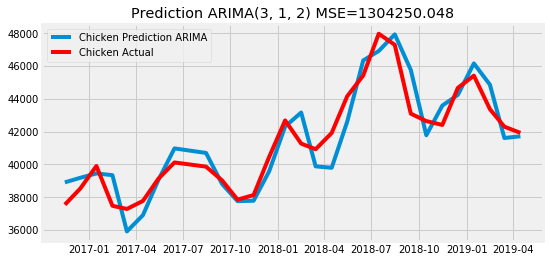

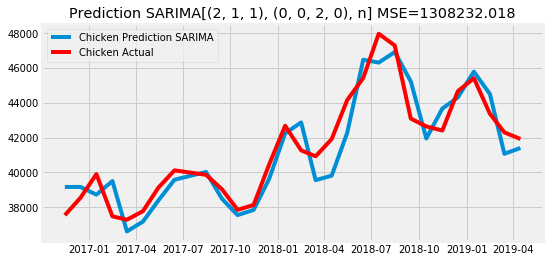

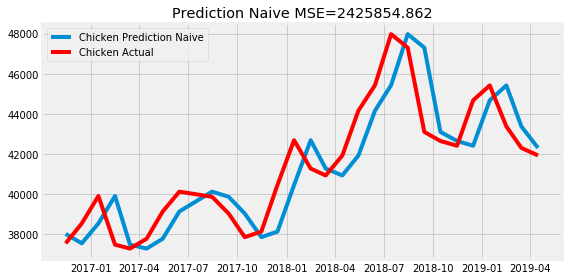

In [58]:
plt.figure(figsize=[8,4])
plt.title('Prediction ARIMA(3, 1, 2) MSE=%.3f' % mse_ARIMA_chicken)
plt.plot(predictions_chicken_ARIMA_original_value)
plt.plot(test_chicken, color='red')
plt.legend(['Chicken Prediction ARIMA', 'Chicken Actual'])
plt.figure(figsize=[8,4])
plt.title('Prediction SARIMA[(2, 1, 1), (0, 0, 2, 0), n] MSE=%.3f' % mse_SARIMA_chicken)
plt.plot(predictions_chicken_SARIMA_original_value)
plt.plot(test_chicken, color='red')
plt.legend(['Chicken Prediction SARIMA', 'Chicken Actual'])
plt.figure(figsize=[8,4])
plt.title('Prediction Naive MSE=%.3f' % mse_naive_chicken)
plt.plot(pred_chicken_naive)
plt.plot(test_chicken, color='red')
plt.legend(['Chicken Prediction Naive', 'Chicken Actual'])
plt.tight_layout()

## Model Egg 

In [30]:
egg_train, egg_test = train_test_builder(X_egg_full, size_test=0.2)
print('train: ', len(egg_train),',', 'test: ', len(egg_test))
egg_train.head(10)

train:  118 , test:  29


,Price
Date,
2007-01-15,9150.7401
2007-02-15,8486.4410
2007-03-15,7993.5490
2007-04-15,8732.9076
2007-05-15,9106.7251
2007-06-15,8559.0000
2007-07-15,9100.0000
2007-08-15,9611.0000
2007-09-15,10300.0000


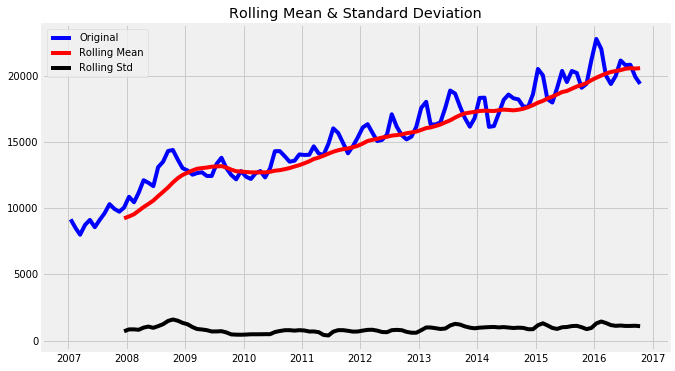

Result of Dickey-Fuller Test
Test Statistic                 -1.024929
p=value                         0.744064
Lags Used                      12.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [31]:
TestStationarity(egg_train)

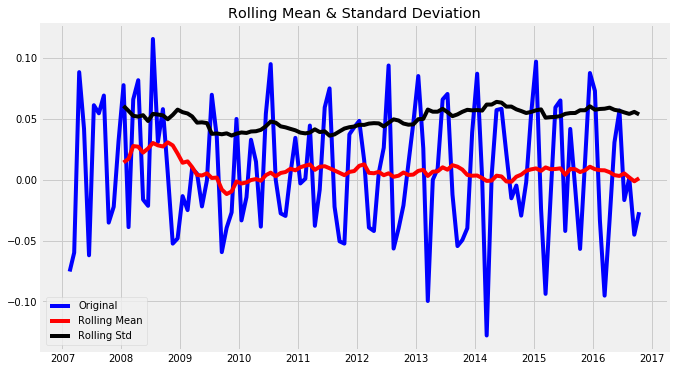

Result of Dickey-Fuller Test
Test Statistic                 -2.164888
p=value                         0.219235
Lags Used                      11.000000
Number of Observation Used    105.000000
critical value (1%)            -3.494220
critical value (5%)            -2.889485
critical value (10%)           -2.581676
dtype: float64


In [33]:
egg_log = np.log(egg_train)
egg_diff = egg_log.diff()
egg_diff.dropna(inplace=True)

TestStationarity(egg_diff)

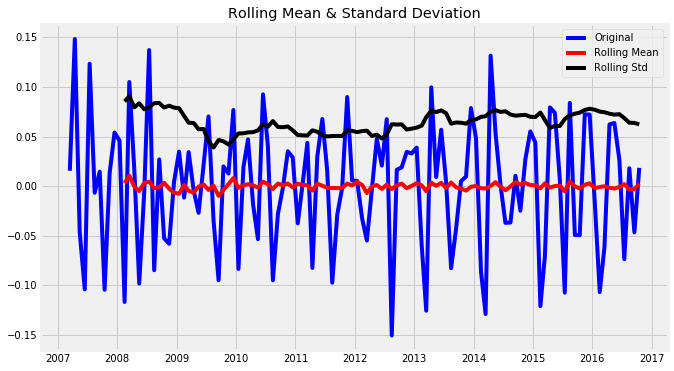

Result of Dickey-Fuller Test
Test Statistic               -8.317358e+00
p=value                       3.650234e-13
Lags Used                     1.000000e+01
Number of Observation Used    1.050000e+02
critical value (1%)          -3.494220e+00
critical value (5%)          -2.889485e+00
critical value (10%)         -2.581676e+00
dtype: float64


In [34]:
egg_diff2 = egg_diff.diff()
egg_diff2.dropna(inplace=True)

TestStationarity(egg_diff2)

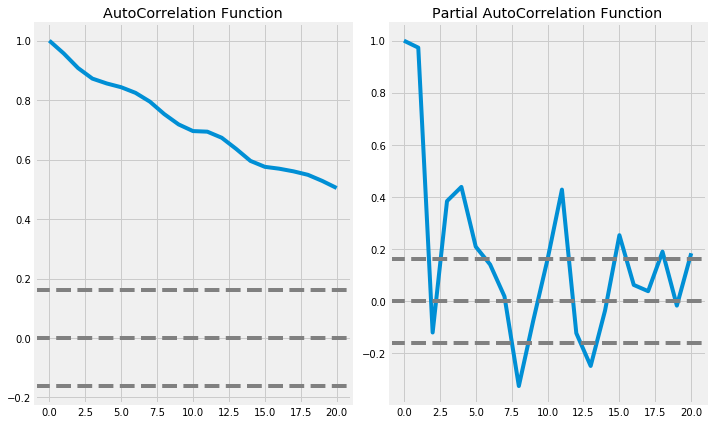

In [41]:
Plot_ACF_PACF(X_egg_full)

In [42]:
train_egg = np.log(egg_train)
train_egg_diff = train_egg.diff()
train_egg_diff.dropna(inplace=True)
test_egg = egg_test
test_egg_log = np.log(test_egg)

In [179]:
p_values = [0, 1, 2, 3, 4, 6, 8, 10]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
warnings.filterwarnings("ignore")

EvaluateParametersARIMA(train_egg, test_egg, p_values, d_values, q_values)

( 1 )  ARIMA (0, 0, 0) MSE= 41839439.86885587
( 2 )  ARIMA (0, 0, 1) MSE= 14291549.917651527
( 3 )
( 4 )  ARIMA (0, 1, 0) MSE= 1398176.8317530395
( 5 )  ARIMA (0, 1, 1) MSE= 1696592.5889107252
( 6 )  ARIMA (0, 1, 2) MSE= 1356089.3533010674
( 7 )  ARIMA (0, 2, 0) MSE= 3240684.881581333
( 8 )  ARIMA (0, 2, 1) MSE= 1427310.0709803551
( 9 )  ARIMA (0, 2, 2) MSE= 1729146.4362482901
( 10 )  ARIMA (1, 0, 0) MSE= 1414296.662930805
( 11 )  ARIMA (1, 0, 1) MSE= 1714203.103712699
( 12 )  ARIMA (1, 0, 2) MSE= 1454340.6614329738
( 13 )  ARIMA (1, 1, 0) MSE= 1482946.0767213423
( 14 )  ARIMA (1, 1, 1) MSE= 1430165.784420701
( 15 )  ARIMA (1, 1, 2) MSE= 1384052.085906836
( 16 )  ARIMA (1, 2, 0) MSE= 2861575.996326341
( 17 )
( 18 )
( 19 )  ARIMA (2, 0, 0) MSE= 1514464.47097158
( 20 )  ARIMA (2, 0, 1) MSE= 1550552.3931280598
( 21 )  ARIMA (2, 0, 2) MSE= 1464573.405466126
( 22 )  ARIMA (2, 1, 0) MSE= 1579888.712839648
( 23 )  ARIMA (2, 1, 1) MSE= 1252587.6880838894
( 24 )  ARIMA (2, 1, 2) MSE= 1007586.56

## ARIMA (2, 1, 2)

In [43]:
egg_ARIMA = StepForwardARIMA([2, 1, 2], train_egg, test_egg_log)

In [44]:
predictions_egg_ARIMA_original_value = np.exp(egg_ARIMA)
predictions_egg_ARIMA_original_value.head(10)

,Price
Date,
2016-11-15,20018.217672
2016-12-15,20027.325132
2017-01-15,21419.314987
2017-02-15,20292.369318
2017-03-15,19000.219388
2017-04-15,18942.324968
2017-05-15,19541.192299
2017-06-15,21388.750530
2017-08-15,20812.222941


In [45]:
ComparePredictions(predictions_egg_ARIMA_original_value, test_egg)

mse_ARIMA_egg = mean_squared_error(test_egg, predictions_egg_ARIMA_original_value)
mae_ARIMA_egg = mean_absolute_error(test_egg, predictions_egg_ARIMA_original_value)
mape_ARIMA_egg = MAPE(predictions_egg_ARIMA_original_value, test_egg)

print('MSE: ', mse_ARIMA_egg)
print('MAE: ', mae_ARIMA_egg)
print('MAPE: ', mape_ARIMA_egg)

-------------------- Compare Predictions --------------------
predicted:  20018.21767177209 , expected:  18909.0 , error:  1109.2176717720904
predicted:  20027.325132305235 , expected:  20654.0 , error:  626.6748676947645
predicted:  21419.314986525183 , expected:  20590.0 , error:  829.3149865251835
predicted:  20292.369317672154 , expected:  19703.0 , error:  589.3693176721536
predicted:  19000.2193880206 , expected:  19181.0 , error:  180.78061197940042
predicted:  18942.32496772645 , expected:  19008.0 , error:  65.67503227354973
predicted:  19541.19229879152 , expected:  20515.0 , error:  973.8077012084796
predicted:  21388.7505302154 , expected:  20439.0 , error:  949.7505302153986
predicted:  20812.22294069282 , expected:  21375.0 , error:  562.77705930718
predicted:  21109.032892414256 , expected:  20811.0 , error:  298.0328924142559
predicted:  20294.685328912008 , expected:  20395.0 , error:  100.31467108799188
predicted:  20294.594153849066 , expected:  20772.0 , error:  477

## SARIMA 

In [55]:
EvaluateParametersSARIMA(train_egg, test_egg)

( 1 ) SARIMA [(0, 0, 0), (0, 0, 0, 0), 'n'] MSE= 473883046.2758621
( 2 ) SARIMA [(0, 0, 0), (0, 0, 0, 4), 'n'] MSE= 473883046.2758621
( 3 ) SARIMA [(0, 0, 0), (0, 0, 0, 12), 'n'] MSE= 473883046.2758621
( 4 ) SARIMA [(0, 0, 0), (0, 0, 1, 0), 'n'] MSE= 469035747.9739826
( 5 ) SARIMA [(0, 0, 0), (0, 0, 1, 4), 'n'] MSE= 470121684.263271
( 6 ) SARIMA [(0, 0, 0), (0, 0, 1, 12), 'n'] MSE= 470129584.3829282
( 7 ) SARIMA [(0, 0, 0), (0, 0, 2, 0), 'n'] MSE= 413439280.1055486
( 8 ) SARIMA [(0, 0, 0), (0, 0, 2, 4), 'n'] MSE= 438624577.9599934
( 9 ) SARIMA [(0, 0, 0), (0, 0, 2, 12), 'n'] MSE= 461998675.46825516
( 10 )
( 11 ) SARIMA [(0, 0, 0), (0, 1, 0, 4), 'n'] MSE= 2514293.8275862033
( 12 ) SARIMA [(0, 0, 0), (0, 1, 0, 12), 'n'] MSE= 3759008.068965509
( 13 )
( 14 ) SARIMA [(0, 0, 0), (0, 1, 1, 4), 'n'] MSE= 2398875.4898201097
( 15 ) SARIMA [(0, 0, 0), (0, 1, 1, 12), 'n'] MSE= 3897142.720086062
( 16 )
( 17 ) SARIMA [(0, 0, 0), (0, 1, 2, 4), 'n'] MSE= 2656795.4647870054
( 18 ) SARIMA [(0, 0, 0), (0

( 141 ) SARIMA [(0, 0, 0), (1, 1, 1, 12), 't'] MSE= 3366448.5054678023
( 142 )
( 143 ) SARIMA [(0, 0, 0), (1, 1, 2, 4), 't'] MSE= 2530864.7850106526
( 144 ) SARIMA [(0, 0, 0), (1, 1, 2, 12), 't'] MSE= 3444886.5076309326
( 145 ) SARIMA [(0, 0, 0), (2, 0, 0, 0), 't'] MSE= 1514231.0828859704
( 146 ) SARIMA [(0, 0, 0), (2, 0, 0, 4), 't'] MSE= 2333896.978127011
( 147 ) SARIMA [(0, 0, 0), (2, 0, 0, 12), 't'] MSE= 2563094.482135299
( 148 ) SARIMA [(0, 0, 0), (2, 0, 1, 0), 't'] MSE= 11922229.18898519
( 149 ) SARIMA [(0, 0, 0), (2, 0, 1, 4), 't'] MSE= 2544661.839714378
( 150 ) SARIMA [(0, 0, 0), (2, 0, 1, 12), 't'] MSE= 2747590.184951634
( 151 ) SARIMA [(0, 0, 0), (2, 0, 2, 0), 't'] MSE= 2221746.18983693
( 152 ) SARIMA [(0, 0, 0), (2, 0, 2, 4), 't'] MSE= 2016928.0404795199
( 153 ) SARIMA [(0, 0, 0), (2, 0, 2, 12), 't'] MSE= 2720371.567739
( 154 )
( 155 ) SARIMA [(0, 0, 0), (2, 1, 0, 4), 't'] MSE= 2195345.439752304
( 156 ) SARIMA [(0, 0, 0), (2, 1, 0, 12), 't'] MSE= 3816773.937971442
( 157 )
( 1

( 278 ) SARIMA [(0, 0, 1), (0, 0, 2, 4), 'c'] MSE= 7218605.372781345
( 279 ) SARIMA [(0, 0, 1), (0, 0, 2, 12), 'c'] MSE= 11869522.820801254
( 280 )
( 281 ) SARIMA [(0, 0, 1), (0, 1, 0, 4), 'c'] MSE= 2284041.9081781614
( 282 ) SARIMA [(0, 0, 1), (0, 1, 0, 12), 'c'] MSE= 2889056.627268876
( 283 )
( 284 ) SARIMA [(0, 0, 1), (0, 1, 1, 4), 'c'] MSE= 1907763.2649040958
( 285 ) SARIMA [(0, 0, 1), (0, 1, 1, 12), 'c'] MSE= 1899542.8146369765
( 286 )
( 287 ) SARIMA [(0, 0, 1), (0, 1, 2, 4), 'c'] MSE= 1592922.850867562
( 288 ) SARIMA [(0, 0, 1), (0, 1, 2, 12), 'c'] MSE= 1867482.998803591
( 289 ) SARIMA [(0, 0, 1), (1, 0, 0, 0), 'c'] MSE= 1653514.5412004483
( 290 ) SARIMA [(0, 0, 1), (1, 0, 0, 4), 'c'] MSE= 2148685.5819559046
( 291 ) SARIMA [(0, 0, 1), (1, 0, 0, 12), 'c'] MSE= 2410708.106694971
( 292 ) SARIMA [(0, 0, 1), (1, 0, 1, 0), 'c'] MSE= 1687117.9687599388
( 293 ) SARIMA [(0, 0, 1), (1, 0, 1, 4), 'c'] MSE= 2137274.1283826577
( 294 ) SARIMA [(0, 0, 1), (1, 0, 1, 12), 'c'] MSE= 2398068.390116

( 416 ) SARIMA [(0, 0, 1), (2, 0, 0, 4), 'ct'] MSE= 1433793.6366841292
( 417 ) SARIMA [(0, 0, 1), (2, 0, 0, 12), 'ct'] MSE= 1626668.4546470416
( 418 ) SARIMA [(0, 0, 1), (2, 0, 1, 0), 'ct'] MSE= 3091068.4627489164
( 419 ) SARIMA [(0, 0, 1), (2, 0, 1, 4), 'ct'] MSE= 1438952.2074834101
( 420 ) SARIMA [(0, 0, 1), (2, 0, 1, 12), 'ct'] MSE= 1747523.771987056
( 421 ) SARIMA [(0, 0, 1), (2, 0, 2, 0), 'ct'] MSE= 3142657.7421360146
( 422 ) SARIMA [(0, 0, 1), (2, 0, 2, 4), 'ct'] MSE= 1400645.448549655
( 423 ) SARIMA [(0, 0, 1), (2, 0, 2, 12), 'ct'] MSE= 2449629.2418065076
( 424 )
( 425 ) SARIMA [(0, 0, 1), (2, 1, 0, 4), 'ct'] MSE= 1823550.3372958994
( 426 ) SARIMA [(0, 0, 1), (2, 1, 0, 12), 'ct'] MSE= 1784147.9353170162
( 427 )
( 428 ) SARIMA [(0, 0, 1), (2, 1, 1, 4), 'ct'] MSE= 2125007.575842021
( 429 ) SARIMA [(0, 0, 1), (2, 1, 1, 12), 'ct'] MSE= 1755618.1804728159
( 430 )
( 431 ) SARIMA [(0, 0, 1), (2, 1, 2, 4), 'ct'] MSE= 2223508.4975867113
( 432 ) SARIMA [(0, 0, 1), (2, 1, 2, 12), 'ct'] MSE

( 554 ) SARIMA [(0, 1, 0), (0, 1, 1, 4), 't'] MSE= 1801090.052258551
( 555 ) SARIMA [(0, 1, 0), (0, 1, 1, 12), 't'] MSE= 1816303.0454962011
( 556 )
( 557 ) SARIMA [(0, 1, 0), (0, 1, 2, 4), 't'] MSE= 1673651.0717433288
( 558 ) SARIMA [(0, 1, 0), (0, 1, 2, 12), 't'] MSE= 1616724.8564429607
( 559 ) SARIMA [(0, 1, 0), (1, 0, 0, 0), 't'] MSE= 1524829.3991935751
( 560 ) SARIMA [(0, 1, 0), (1, 0, 0, 4), 't'] MSE= 1433888.8484469736
( 561 ) SARIMA [(0, 1, 0), (1, 0, 0, 12), 't'] MSE= 1483567.5632982226
( 562 ) SARIMA [(0, 1, 0), (1, 0, 1, 0), 't'] MSE= 1542627.3798508153
( 563 ) SARIMA [(0, 1, 0), (1, 0, 1, 4), 't'] MSE= 1412800.8009506941
( 564 ) SARIMA [(0, 1, 0), (1, 0, 1, 12), 't'] MSE= 1574569.3631571312
( 565 ) SARIMA [(0, 1, 0), (1, 0, 2, 0), 't'] MSE= 1503293.921998006
( 566 ) SARIMA [(0, 1, 0), (1, 0, 2, 4), 't'] MSE= 1489244.5807608312
( 567 ) SARIMA [(0, 1, 0), (1, 0, 2, 12), 't'] MSE= 1547879.3605980196
( 568 )
( 569 ) SARIMA [(0, 1, 0), (1, 1, 0, 4), 't'] MSE= 2454121.2431668197
(

( 690 ) SARIMA [(0, 1, 1), (2, 0, 1, 12), 'n'] MSE= 1411960.886077255
( 691 ) SARIMA [(0, 1, 1), (2, 0, 2, 0), 'n'] MSE= 1227015.5555422565
( 692 ) SARIMA [(0, 1, 1), (2, 0, 2, 4), 'n'] MSE= 1531468.670292038
( 693 ) SARIMA [(0, 1, 1), (2, 0, 2, 12), 'n'] MSE= 1347195.8263981338
( 694 )
( 695 ) SARIMA [(0, 1, 1), (2, 1, 0, 4), 'n'] MSE= 1611106.1183330764
( 696 ) SARIMA [(0, 1, 1), (2, 1, 0, 12), 'n'] MSE= 1700852.1954245425
( 697 )
( 698 ) SARIMA [(0, 1, 1), (2, 1, 1, 4), 'n'] MSE= 1682921.4192247028
( 699 ) SARIMA [(0, 1, 1), (2, 1, 1, 12), 'n'] MSE= 1721819.6815598141
( 700 )
( 701 ) SARIMA [(0, 1, 1), (2, 1, 2, 4), 'n'] MSE= 1707007.0710295031
( 702 ) SARIMA [(0, 1, 1), (2, 1, 2, 12), 'n'] MSE= 1663135.4294222917
( 703 ) SARIMA [(0, 1, 1), (0, 0, 0, 0), 'c'] MSE= 1670117.9749718506
( 704 ) SARIMA [(0, 1, 1), (0, 0, 0, 4), 'c'] MSE= 1670117.9749718506
( 705 ) SARIMA [(0, 1, 1), (0, 0, 0, 12), 'c'] MSE= 1670117.9749718506
( 706 ) SARIMA [(0, 1, 1), (0, 0, 1, 0), 'c'] MSE= 1364863.789

( 828 ) SARIMA [(0, 1, 1), (0, 1, 2, 12), 'ct'] MSE= 1603752.023146137
( 829 ) SARIMA [(0, 1, 1), (1, 0, 0, 0), 'ct'] MSE= 1650885.572821741
( 830 ) SARIMA [(0, 1, 1), (1, 0, 0, 4), 'ct'] MSE= 1506173.363482701
( 831 ) SARIMA [(0, 1, 1), (1, 0, 0, 12), 'ct'] MSE= 1687370.602211766
( 832 ) SARIMA [(0, 1, 1), (1, 0, 1, 0), 'ct'] MSE= 1644844.1712715493
( 833 ) SARIMA [(0, 1, 1), (1, 0, 1, 4), 'ct'] MSE= 1497189.9224345551
( 834 ) SARIMA [(0, 1, 1), (1, 0, 1, 12), 'ct'] MSE= 1729263.9648251939
( 835 ) SARIMA [(0, 1, 1), (1, 0, 2, 0), 'ct'] MSE= 1817112.8754208104
( 836 ) SARIMA [(0, 1, 1), (1, 0, 2, 4), 'ct'] MSE= 1518544.9205466711
( 837 ) SARIMA [(0, 1, 1), (1, 0, 2, 12), 'ct'] MSE= 1749821.317996778
( 838 )
( 839 ) SARIMA [(0, 1, 1), (1, 1, 0, 4), 'ct'] MSE= 3105259.044827179
( 840 ) SARIMA [(0, 1, 1), (1, 1, 0, 12), 'ct'] MSE= 1857666.244034004
( 841 )
( 842 ) SARIMA [(0, 1, 1), (1, 1, 1, 4), 'ct'] MSE= 2507848.57447928
( 843 ) SARIMA [(0, 1, 1), (1, 1, 1, 12), 'ct'] MSE= 1926517.6045

( 965 ) SARIMA [(0, 2, 0), (2, 1, 0, 4), 'c'] MSE= 4469303.047985649
( 966 ) SARIMA [(0, 2, 0), (2, 1, 0, 12), 'c'] MSE= 5245051.976871517
( 967 )
( 968 ) SARIMA [(0, 2, 0), (2, 1, 1, 4), 'c'] MSE= 4585170.882261118
( 969 ) SARIMA [(0, 2, 0), (2, 1, 1, 12), 'c'] MSE= 5409893.008221073
( 970 )
( 971 ) SARIMA [(0, 2, 0), (2, 1, 2, 4), 'c'] MSE= 4638555.449796014
( 972 ) SARIMA [(0, 2, 0), (2, 1, 2, 12), 'c'] MSE= 5054342.287458513
( 973 ) SARIMA [(0, 2, 0), (0, 0, 0, 0), 't'] MSE= 3288209.6363666304
( 974 ) SARIMA [(0, 2, 0), (0, 0, 0, 4), 't'] MSE= 3288209.6363666304
( 975 ) SARIMA [(0, 2, 0), (0, 0, 0, 12), 't'] MSE= 3288209.6363666304
( 976 ) SARIMA [(0, 2, 0), (0, 0, 1, 0), 't'] MSE= 2326495.1132554184
( 977 ) SARIMA [(0, 2, 0), (0, 0, 1, 4), 't'] MSE= 3296012.947373625
( 978 ) SARIMA [(0, 2, 0), (0, 0, 1, 12), 't'] MSE= 3552725.270448148
( 979 ) SARIMA [(0, 2, 0), (0, 0, 2, 0), 't'] MSE= 2394225.1052205497
( 980 ) SARIMA [(0, 2, 0), (0, 0, 2, 4), 't'] MSE= 3321239.7670790763
( 981 )

( 1101 ) SARIMA [(0, 2, 1), (1, 0, 0, 12), 'n'] MSE= 1456064.8592047796
( 1102 ) SARIMA [(0, 2, 1), (1, 0, 1, 0), 'n'] MSE= 1244172.176975923
( 1103 ) SARIMA [(0, 2, 1), (1, 0, 1, 4), 'n'] MSE= 1454177.8478572292
( 1104 ) SARIMA [(0, 2, 1), (1, 0, 1, 12), 'n'] MSE= 1480097.9568867693
( 1105 ) SARIMA [(0, 2, 1), (1, 0, 2, 0), 'n'] MSE= 1398871.3597428878
( 1106 ) SARIMA [(0, 2, 1), (1, 0, 2, 4), 'n'] MSE= 1392876.6748201526
( 1107 ) SARIMA [(0, 2, 1), (1, 0, 2, 12), 'n'] MSE= 1636864.605734518
( 1108 )
( 1109 ) SARIMA [(0, 2, 1), (1, 1, 0, 4), 'n'] MSE= 2697317.7956293956
( 1110 ) SARIMA [(0, 2, 1), (1, 1, 0, 12), 'n'] MSE= 1839328.0347373767
( 1111 )
( 1112 ) SARIMA [(0, 2, 1), (1, 1, 1, 4), 'n'] MSE= 1754737.4938393356
( 1113 ) SARIMA [(0, 2, 1), (1, 1, 1, 12), 'n'] MSE= 1917709.2155704522
( 1114 )
( 1115 ) SARIMA [(0, 2, 1), (1, 1, 2, 4), 'n'] MSE= 1646389.1936072311
( 1116 ) SARIMA [(0, 2, 1), (1, 1, 2, 12), 'n'] MSE= 1912674.827868626
( 1117 ) SARIMA [(0, 2, 1), (2, 0, 0, 0), 'n'] 

( 1236 ) SARIMA [(0, 2, 1), (2, 1, 0, 12), 't'] MSE= 2267979.2255263613
( 1237 )
( 1238 ) SARIMA [(0, 2, 1), (2, 1, 1, 4), 't'] MSE= 3262456.0940811844
( 1239 ) SARIMA [(0, 2, 1), (2, 1, 1, 12), 't'] MSE= 2296539.7873864584
( 1240 )
( 1241 ) SARIMA [(0, 2, 1), (2, 1, 2, 4), 't'] MSE= 2681944.8862957354
( 1242 ) SARIMA [(0, 2, 1), (2, 1, 2, 12), 't'] MSE= 2175340.8640238354
( 1243 ) SARIMA [(0, 2, 1), (0, 0, 0, 0), 'ct'] MSE= 2443169.584974277
( 1244 ) SARIMA [(0, 2, 1), (0, 0, 0, 4), 'ct'] MSE= 2443169.584974277
( 1245 ) SARIMA [(0, 2, 1), (0, 0, 0, 12), 'ct'] MSE= 2443169.584974277
( 1246 ) SARIMA [(0, 2, 1), (0, 0, 1, 0), 'ct'] MSE= 2090298.7087748896
( 1247 ) SARIMA [(0, 2, 1), (0, 0, 1, 4), 'ct'] MSE= 2481086.7315807645
( 1248 ) SARIMA [(0, 2, 1), (0, 0, 1, 12), 'ct'] MSE= 2354582.263359048
( 1249 ) SARIMA [(0, 2, 1), (0, 0, 2, 0), 'ct'] MSE= 1782629.4717413897
( 1250 ) SARIMA [(0, 2, 1), (0, 0, 2, 4), 'ct'] MSE= 2430171.6128370035
( 1251 ) SARIMA [(0, 2, 1), (0, 0, 2, 12), 'ct'] M

( 1371 ) SARIMA [(1, 0, 0), (1, 0, 0, 12), 'c'] MSE= 1376390.1301685919
( 1372 ) SARIMA [(1, 0, 0), (1, 0, 1, 0), 'c'] MSE= 1716177.9801183718
( 1373 ) SARIMA [(1, 0, 0), (1, 0, 1, 4), 'c'] MSE= 1453308.9796871112
( 1374 ) SARIMA [(1, 0, 0), (1, 0, 1, 12), 'c'] MSE= 1362645.2317018933
( 1375 ) SARIMA [(1, 0, 0), (1, 0, 2, 0), 'c'] MSE= 1617520.4146468104
( 1376 ) SARIMA [(1, 0, 0), (1, 0, 2, 4), 'c'] MSE= 1460413.6347935903
( 1377 ) SARIMA [(1, 0, 0), (1, 0, 2, 12), 'c'] MSE= 1412393.165457801
( 1378 )
( 1379 ) SARIMA [(1, 0, 0), (1, 1, 0, 4), 'c'] MSE= 1833091.4344358633
( 1380 ) SARIMA [(1, 0, 0), (1, 1, 0, 12), 'c'] MSE= 1521043.0258455689
( 1381 )
( 1382 ) SARIMA [(1, 0, 0), (1, 1, 1, 4), 'c'] MSE= 1408690.8983418546
( 1383 ) SARIMA [(1, 0, 0), (1, 1, 1, 12), 'c'] MSE= 1605008.9551244774
( 1384 )
( 1385 ) SARIMA [(1, 0, 0), (1, 1, 2, 4), 'c'] MSE= 1384575.6583995942
( 1386 ) SARIMA [(1, 0, 0), (1, 1, 2, 12), 'c'] MSE= 1552155.583188191
( 1387 ) SARIMA [(1, 0, 0), (2, 0, 0, 0), 'c']

( 1505 ) SARIMA [(1, 0, 0), (2, 1, 0, 4), 'ct'] MSE= 1425593.9289653976
( 1506 ) SARIMA [(1, 0, 0), (2, 1, 0, 12), 'ct'] MSE= 2034130.8040936291
( 1507 )
( 1508 ) SARIMA [(1, 0, 0), (2, 1, 1, 4), 'ct'] MSE= 1590153.6964758688
( 1509 ) SARIMA [(1, 0, 0), (2, 1, 1, 12), 'ct'] MSE= 1973249.1010029814
( 1510 )
( 1511 ) SARIMA [(1, 0, 0), (2, 1, 2, 4), 'ct'] MSE= 1826340.4051231074
( 1512 ) SARIMA [(1, 0, 0), (2, 1, 2, 12), 'ct'] MSE= 1779789.6318427105
( 1513 ) SARIMA [(1, 0, 1), (0, 0, 0, 0), 'n'] MSE= 1672950.0011559038
( 1514 ) SARIMA [(1, 0, 1), (0, 0, 0, 4), 'n'] MSE= 1672950.0011559038
( 1515 ) SARIMA [(1, 0, 1), (0, 0, 0, 12), 'n'] MSE= 1672950.0011559038
( 1516 ) SARIMA [(1, 0, 1), (0, 0, 1, 0), 'n'] MSE= 1333327.725134087
( 1517 ) SARIMA [(1, 0, 1), (0, 0, 1, 4), 'n'] MSE= 1701445.5962233504
( 1518 ) SARIMA [(1, 0, 1), (0, 0, 1, 12), 'n'] MSE= 1669175.0033416608
( 1519 ) SARIMA [(1, 0, 1), (0, 0, 2, 0), 'n'] MSE= 1320178.6281489925
( 1520 ) SARIMA [(1, 0, 1), (0, 0, 2, 4), 'n'] MS

( 1641 ) SARIMA [(1, 0, 1), (1, 0, 0, 12), 't'] MSE= 2445543.0139340367
( 1642 ) SARIMA [(1, 0, 1), (1, 0, 1, 0), 't'] MSE= 1848550.7896538174
( 1643 ) SARIMA [(1, 0, 1), (1, 0, 1, 4), 't'] MSE= 2131341.8306921814
( 1644 ) SARIMA [(1, 0, 1), (1, 0, 1, 12), 't'] MSE= 2164014.635566907
( 1645 ) SARIMA [(1, 0, 1), (1, 0, 2, 0), 't'] MSE= 2628440.995652255
( 1646 ) SARIMA [(1, 0, 1), (1, 0, 2, 4), 't'] MSE= 1864097.6990653225
( 1647 ) SARIMA [(1, 0, 1), (1, 0, 2, 12), 't'] MSE= 2046045.3120855617
( 1648 )
( 1649 ) SARIMA [(1, 0, 1), (1, 1, 0, 4), 't'] MSE= 2497932.8451034827
( 1650 ) SARIMA [(1, 0, 1), (1, 1, 0, 12), 't'] MSE= 1922487.2025134966
( 1651 )
( 1652 ) SARIMA [(1, 0, 1), (1, 1, 1, 4), 't'] MSE= 2344912.843259204
( 1653 ) SARIMA [(1, 0, 1), (1, 1, 1, 12), 't'] MSE= 1828234.759383407
( 1654 )
( 1655 ) SARIMA [(1, 0, 1), (1, 1, 2, 4), 't'] MSE= 2379636.974399586
( 1656 ) SARIMA [(1, 0, 1), (1, 1, 2, 12), 't'] MSE= 1968519.3777953049
( 1657 ) SARIMA [(1, 0, 1), (2, 0, 0, 0), 't'] MS

( 1775 ) SARIMA [(1, 1, 0), (2, 1, 0, 4), 'n'] MSE= 1595378.1324582188
( 1776 ) SARIMA [(1, 1, 0), (2, 1, 0, 12), 'n'] MSE= 1723408.9643705308
( 1777 )
( 1778 ) SARIMA [(1, 1, 0), (2, 1, 1, 4), 'n'] MSE= 1657877.9615672685
( 1779 ) SARIMA [(1, 1, 0), (2, 1, 1, 12), 'n'] MSE= 1739406.8692589304
( 1780 )
( 1781 ) SARIMA [(1, 1, 0), (2, 1, 2, 4), 'n'] MSE= 1749601.0434774058
( 1782 ) SARIMA [(1, 1, 0), (2, 1, 2, 12), 'n'] MSE= 1723392.000624174
( 1783 ) SARIMA [(1, 1, 0), (0, 0, 0, 0), 'c'] MSE= 1483697.4992213713
( 1784 ) SARIMA [(1, 1, 0), (0, 0, 0, 4), 'c'] MSE= 1483697.4992213713
( 1785 ) SARIMA [(1, 1, 0), (0, 0, 0, 12), 'c'] MSE= 1483697.4992213713
( 1786 ) SARIMA [(1, 1, 0), (0, 0, 1, 0), 'c'] MSE= 1654865.4781745777
( 1787 ) SARIMA [(1, 1, 0), (0, 0, 1, 4), 'c'] MSE= 1509312.9101841466
( 1788 ) SARIMA [(1, 1, 0), (0, 0, 1, 12), 'c'] MSE= 1414008.7694970649
( 1789 ) SARIMA [(1, 1, 0), (0, 0, 2, 0), 'c'] MSE= 1388368.6754280694
( 1790 ) SARIMA [(1, 1, 0), (0, 0, 2, 4), 'c'] MSE= 151

( 1911 ) SARIMA [(1, 1, 0), (1, 0, 0, 12), 'ct'] MSE= 1707174.281531256
( 1912 ) SARIMA [(1, 1, 0), (1, 0, 1, 0), 'ct'] MSE= 1658737.7440806306
( 1913 ) SARIMA [(1, 1, 0), (1, 0, 1, 4), 'ct'] MSE= 1555187.0044093053
( 1914 ) SARIMA [(1, 1, 0), (1, 0, 1, 12), 'ct'] MSE= 1899806.0325023155
( 1915 ) SARIMA [(1, 1, 0), (1, 0, 2, 0), 'ct'] MSE= 1929130.6277350665
( 1916 ) SARIMA [(1, 1, 0), (1, 0, 2, 4), 'ct'] MSE= 1568341.2183088977
( 1917 ) SARIMA [(1, 1, 0), (1, 0, 2, 12), 'ct'] MSE= 1665034.5476010125
( 1918 )
( 1919 ) SARIMA [(1, 1, 0), (1, 1, 0, 4), 'ct'] MSE= 2706793.1840265724
( 1920 ) SARIMA [(1, 1, 0), (1, 1, 0, 12), 'ct'] MSE= 1883544.1761704637
( 1921 )
( 1922 ) SARIMA [(1, 1, 0), (1, 1, 1, 4), 'ct'] MSE= 2313723.511996341
( 1923 ) SARIMA [(1, 1, 0), (1, 1, 1, 12), 'ct'] MSE= 1907185.7157723277
( 1924 )
( 1925 ) SARIMA [(1, 1, 0), (1, 1, 2, 4), 'ct'] MSE= 1940803.0615113792
( 1926 ) SARIMA [(1, 1, 0), (1, 1, 2, 12), 'ct'] MSE= 1703836.5516300655
( 1927 ) SARIMA [(1, 1, 0), (2, 0

( 2045 ) SARIMA [(1, 1, 1), (2, 1, 0, 4), 'c'] MSE= 1507031.8308563984
( 2046 ) SARIMA [(1, 1, 1), (2, 1, 0, 12), 'c'] MSE= 1729037.7063956189
( 2047 )
( 2048 ) SARIMA [(1, 1, 1), (2, 1, 1, 4), 'c'] MSE= 1561874.4139050366
( 2049 ) SARIMA [(1, 1, 1), (2, 1, 1, 12), 'c'] MSE= 1726974.4749722944
( 2050 )
( 2051 ) SARIMA [(1, 1, 1), (2, 1, 2, 4), 'c'] MSE= 1660654.1354578948
( 2052 ) SARIMA [(1, 1, 1), (2, 1, 2, 12), 'c'] MSE= 1778847.9311720373
( 2053 ) SARIMA [(1, 1, 1), (0, 0, 0, 0), 't'] MSE= 1541244.4714055313
( 2054 ) SARIMA [(1, 1, 1), (0, 0, 0, 4), 't'] MSE= 1541244.4714055313
( 2055 ) SARIMA [(1, 1, 1), (0, 0, 0, 12), 't'] MSE= 1541244.4714055313
( 2056 ) SARIMA [(1, 1, 1), (0, 0, 1, 0), 't'] MSE= 1668718.1760572274
( 2057 ) SARIMA [(1, 1, 1), (0, 0, 1, 4), 't'] MSE= 1551366.4694593616
( 2058 ) SARIMA [(1, 1, 1), (0, 0, 1, 12), 't'] MSE= 1454567.5038866324
( 2059 ) SARIMA [(1, 1, 1), (0, 0, 2, 0), 't'] MSE= 1849858.1823099693
( 2060 ) SARIMA [(1, 1, 1), (0, 0, 2, 4), 't'] MSE= 15

( 2180 ) SARIMA [(1, 2, 0), (1, 0, 0, 4), 'n'] MSE= 2897265.6071932344
( 2181 ) SARIMA [(1, 2, 0), (1, 0, 0, 12), 'n'] MSE= 2613981.4620320406
( 2182 ) SARIMA [(1, 2, 0), (1, 0, 1, 0), 'n'] MSE= 1481591.4157858891
( 2183 ) SARIMA [(1, 2, 0), (1, 0, 1, 4), 'n'] MSE= 2903131.909318228
( 2184 ) SARIMA [(1, 2, 0), (1, 0, 1, 12), 'n'] MSE= 2586411.5454608346
( 2185 ) SARIMA [(1, 2, 0), (1, 0, 2, 0), 'n'] MSE= 1646091.1065111177
( 2186 ) SARIMA [(1, 2, 0), (1, 0, 2, 4), 'n'] MSE= 2852847.2436652454
( 2187 ) SARIMA [(1, 2, 0), (1, 0, 2, 12), 'n'] MSE= 2605996.56326454
( 2188 )
( 2189 ) SARIMA [(1, 2, 0), (1, 1, 0, 4), 'n'] MSE= 4779670.690897957
( 2190 ) SARIMA [(1, 2, 0), (1, 1, 0, 12), 'n'] MSE= 3065602.6817455227
( 2191 )
( 2192 ) SARIMA [(1, 2, 0), (1, 1, 1, 4), 'n'] MSE= 3651276.5685632187
( 2193 ) SARIMA [(1, 2, 0), (1, 1, 1, 12), 'n'] MSE= 2990620.8771044696
( 2194 )
( 2195 ) SARIMA [(1, 2, 0), (1, 1, 2, 4), 'n'] MSE= 3338527.321140993
( 2196 ) SARIMA [(1, 2, 0), (1, 1, 2, 12), 'n'] MS

( 2315 ) SARIMA [(1, 2, 0), (2, 1, 0, 4), 't'] MSE= 2679150.540722961
( 2316 ) SARIMA [(1, 2, 0), (2, 1, 0, 12), 't'] MSE= 3215263.051191911
( 2317 )
( 2318 ) SARIMA [(1, 2, 0), (2, 1, 1, 4), 't'] MSE= 2911232.429778007
( 2319 ) SARIMA [(1, 2, 0), (2, 1, 1, 12), 't'] MSE= 3432856.114479696
( 2320 )
( 2321 ) SARIMA [(1, 2, 0), (2, 1, 2, 4), 't'] MSE= 3242742.5768557447
( 2322 ) SARIMA [(1, 2, 0), (2, 1, 2, 12), 't'] MSE= 3007193.8092190726
( 2323 ) SARIMA [(1, 2, 0), (0, 0, 0, 0), 'ct'] MSE= 2919016.223720499
( 2324 ) SARIMA [(1, 2, 0), (0, 0, 0, 4), 'ct'] MSE= 2919016.223720499
( 2325 ) SARIMA [(1, 2, 0), (0, 0, 0, 12), 'ct'] MSE= 2919016.223720499
( 2326 ) SARIMA [(1, 2, 0), (0, 0, 1, 0), 'ct'] MSE= 2407828.714017983
( 2327 ) SARIMA [(1, 2, 0), (0, 0, 1, 4), 'ct'] MSE= 2917684.172355613
( 2328 ) SARIMA [(1, 2, 0), (0, 0, 1, 12), 'ct'] MSE= 2756104.2039270382
( 2329 ) SARIMA [(1, 2, 0), (0, 0, 2, 0), 'ct'] MSE= 2073309.3237234538
( 2330 ) SARIMA [(1, 2, 0), (0, 0, 2, 4), 'ct'] MSE= 281

( 2450 ) SARIMA [(1, 2, 1), (1, 0, 0, 4), 'c'] MSE= 52193854532.91258
( 2451 ) SARIMA [(1, 2, 1), (1, 0, 0, 12), 'c'] MSE= 1534895.3928838861
( 2452 ) SARIMA [(1, 2, 1), (1, 0, 1, 0), 'c'] MSE= 1336134.8392167415
( 2453 ) SARIMA [(1, 2, 1), (1, 0, 1, 4), 'c'] MSE= 1560574.2338479946
( 2454 ) SARIMA [(1, 2, 1), (1, 0, 1, 12), 'c'] MSE= 1831625.7507572651
( 2455 ) SARIMA [(1, 2, 1), (1, 0, 2, 0), 'c'] MSE= 1343116.2040497714
( 2456 ) SARIMA [(1, 2, 1), (1, 0, 2, 4), 'c'] MSE= 1544154.8128647835
( 2457 ) SARIMA [(1, 2, 1), (1, 0, 2, 12), 'c'] MSE= 1543765.772919371
( 2458 )
( 2459 ) SARIMA [(1, 2, 1), (1, 1, 0, 4), 'c'] MSE= 2655917.919841882
( 2460 ) SARIMA [(1, 2, 1), (1, 1, 0, 12), 'c'] MSE= 1799015.4305294708
( 2461 )
( 2462 ) SARIMA [(1, 2, 1), (1, 1, 1, 4), 'c'] MSE= 2012863.4693501533
( 2463 ) SARIMA [(1, 2, 1), (1, 1, 1, 12), 'c'] MSE= 2340305.5212499695
( 2464 )
( 2465 ) SARIMA [(1, 2, 1), (1, 1, 2, 4), 'c'] MSE= 1909408.1799439148
( 2466 ) SARIMA [(1, 2, 1), (1, 1, 2, 12), 'c'] 

( 2585 ) SARIMA [(1, 2, 1), (2, 1, 0, 4), 'ct'] MSE= 5858149.784628036
( 2586 ) SARIMA [(1, 2, 1), (2, 1, 0, 12), 'ct'] MSE= 2671289.8129417016
( 2587 )
( 2588 ) SARIMA [(1, 2, 1), (2, 1, 1, 4), 'ct'] MSE= 5974982.209181936
( 2589 ) SARIMA [(1, 2, 1), (2, 1, 1, 12), 'ct'] MSE= 2548427.607267547
( 2590 )
( 2591 ) SARIMA [(1, 2, 1), (2, 1, 2, 4), 'ct'] MSE= 5541638.705706398
( 2592 ) SARIMA [(1, 2, 1), (2, 1, 2, 12), 'ct'] MSE= 2851165.0783790876
( 2593 ) SARIMA [(2, 0, 0), (0, 0, 0, 0), 'n'] MSE= 1485862.1971474788
( 2594 ) SARIMA [(2, 0, 0), (0, 0, 0, 4), 'n'] MSE= 1485862.1971474788
( 2595 ) SARIMA [(2, 0, 0), (0, 0, 0, 12), 'n'] MSE= 1485862.1971474788
( 2596 ) SARIMA [(2, 0, 0), (0, 0, 1, 0), 'n'] MSE= 1302069.2316294014
( 2597 ) SARIMA [(2, 0, 0), (0, 0, 1, 4), 'n'] MSE= 1544314.1606232063
( 2598 ) SARIMA [(2, 0, 0), (0, 0, 1, 12), 'n'] MSE= 1418113.5704790654
( 2599 ) SARIMA [(2, 0, 0), (0, 0, 2, 0), 'n'] MSE= 1549549.8496291623
( 2600 ) SARIMA [(2, 0, 0), (0, 0, 2, 4), 'n'] MSE= 

( 2721 ) SARIMA [(2, 0, 0), (1, 0, 0, 12), 't'] MSE= 2170735.398278224
( 2722 ) SARIMA [(2, 0, 0), (1, 0, 1, 0), 't'] MSE= 1884862.9308179712
( 2723 ) SARIMA [(2, 0, 0), (1, 0, 1, 4), 't'] MSE= 2087820.5675581703
( 2724 ) SARIMA [(2, 0, 0), (1, 0, 1, 12), 't'] MSE= 2089520.3253367697
( 2725 ) SARIMA [(2, 0, 0), (1, 0, 2, 0), 't'] MSE= 3411364.687402858
( 2726 ) SARIMA [(2, 0, 0), (1, 0, 2, 4), 't'] MSE= 1825091.3341849851
( 2727 ) SARIMA [(2, 0, 0), (1, 0, 2, 12), 't'] MSE= 1948702.2589602887
( 2728 )
( 2729 ) SARIMA [(2, 0, 0), (1, 1, 0, 4), 't'] MSE= 1951680.7465777886
( 2730 ) SARIMA [(2, 0, 0), (1, 1, 0, 12), 't'] MSE= 1881430.5311926585
( 2731 )
( 2732 ) SARIMA [(2, 0, 0), (1, 1, 1, 4), 't'] MSE= 1871274.6422503423
( 2733 ) SARIMA [(2, 0, 0), (1, 1, 1, 12), 't'] MSE= 1830410.014013682
( 2734 )
( 2735 ) SARIMA [(2, 0, 0), (1, 1, 2, 4), 't'] MSE= 1955711.4261645577
( 2736 ) SARIMA [(2, 0, 0), (1, 1, 2, 12), 't'] MSE= 2088020.3207674779
( 2737 ) SARIMA [(2, 0, 0), (2, 0, 0, 0), 't'] 

( 2855 ) SARIMA [(2, 0, 1), (2, 1, 0, 4), 'n'] MSE= 1569120.6278398507
( 2856 ) SARIMA [(2, 0, 1), (2, 1, 0, 12), 'n'] MSE= 1.0873295605640011e+17
( 2857 )
( 2858 ) SARIMA [(2, 0, 1), (2, 1, 1, 4), 'n'] MSE= 1627123.147141393
( 2859 ) SARIMA [(2, 0, 1), (2, 1, 1, 12), 'n'] MSE= 4.550861116904642e+16
( 2860 )
( 2861 ) SARIMA [(2, 0, 1), (2, 1, 2, 4), 'n'] MSE= 1717500.5590300816
( 2862 ) SARIMA [(2, 0, 1), (2, 1, 2, 12), 'n'] MSE= 3.7720511368976744e+16
( 2863 ) SARIMA [(2, 0, 1), (0, 0, 0, 0), 'c'] MSE= 1619690.9940467267
( 2864 ) SARIMA [(2, 0, 1), (0, 0, 0, 4), 'c'] MSE= 1619690.9940467267
( 2865 ) SARIMA [(2, 0, 1), (0, 0, 0, 12), 'c'] MSE= 1619690.9940467267
( 2866 ) SARIMA [(2, 0, 1), (0, 0, 1, 0), 'c'] MSE= 1482018.2179398008
( 2867 ) SARIMA [(2, 0, 1), (0, 0, 1, 4), 'c'] MSE= 1609651.7458353846
( 2868 ) SARIMA [(2, 0, 1), (0, 0, 1, 12), 'c'] MSE= 2991874.4921049736
( 2869 ) SARIMA [(2, 0, 1), (0, 0, 2, 0), 'c'] MSE= 1914184.953493457
( 2870 ) SARIMA [(2, 0, 1), (0, 0, 2, 4), 'c'

( 2990 ) SARIMA [(2, 0, 1), (1, 0, 0, 4), 'ct'] MSE= 5751752.588809945
( 2991 ) SARIMA [(2, 0, 1), (1, 0, 0, 12), 'ct'] MSE= 5259430.561037638
( 2992 ) SARIMA [(2, 0, 1), (1, 0, 1, 0), 'ct'] MSE= 4014332.126571825
( 2993 ) SARIMA [(2, 0, 1), (1, 0, 1, 4), 'ct'] MSE= 5100088.123461139
( 2994 ) SARIMA [(2, 0, 1), (1, 0, 1, 12), 'ct'] MSE= 6078327.29425576
( 2995 ) SARIMA [(2, 0, 1), (1, 0, 2, 0), 'ct'] MSE= 5333330.929784118
( 2996 ) SARIMA [(2, 0, 1), (1, 0, 2, 4), 'ct'] MSE= 5267435.151431577
( 2997 ) SARIMA [(2, 0, 1), (1, 0, 2, 12), 'ct'] MSE= 8022415.071184825
( 2998 )
( 2999 ) SARIMA [(2, 0, 1), (1, 1, 0, 4), 'ct'] MSE= 1694013.1624998923
( 3000 ) SARIMA [(2, 0, 1), (1, 1, 0, 12), 'ct'] MSE= 1388074020253540.5
( 3001 )
( 3002 ) SARIMA [(2, 0, 1), (1, 1, 1, 4), 'ct'] MSE= 1761441.019859383
( 3003 ) SARIMA [(2, 0, 1), (1, 1, 1, 12), 'ct'] MSE= 1031225384737586.4
( 3004 )
( 3005 ) SARIMA [(2, 0, 1), (1, 1, 2, 4), 'ct'] MSE= 2130340.128192876
( 3006 ) SARIMA [(2, 0, 1), (1, 1, 2, 12), 

( 3125 ) SARIMA [(2, 1, 0), (2, 1, 0, 4), 'c'] MSE= 1689625.51233495
( 3126 ) SARIMA [(2, 1, 0), (2, 1, 0, 12), 'c'] MSE= 1841474.7640652684
( 3127 )
( 3128 ) SARIMA [(2, 1, 0), (2, 1, 1, 4), 'c'] MSE= 1718601.2181130408
( 3129 ) SARIMA [(2, 1, 0), (2, 1, 1, 12), 'c'] MSE= 1940254.7037030836
( 3130 )
( 3131 ) SARIMA [(2, 1, 0), (2, 1, 2, 4), 'c'] MSE= 1822703.4019285457
( 3132 ) SARIMA [(2, 1, 0), (2, 1, 2, 12), 'c'] MSE= 1878232.8031055003
( 3133 ) SARIMA [(2, 1, 0), (0, 0, 0, 0), 't'] MSE= 1602723.6133615072
( 3134 ) SARIMA [(2, 1, 0), (0, 0, 0, 4), 't'] MSE= 1602723.6133615072
( 3135 ) SARIMA [(2, 1, 0), (0, 0, 0, 12), 't'] MSE= 1602723.6133615072
( 3136 ) SARIMA [(2, 1, 0), (0, 0, 1, 0), 't'] MSE= 1903755.2151779144
( 3137 ) SARIMA [(2, 1, 0), (0, 0, 1, 4), 't'] MSE= 1615992.5919122712
( 3138 ) SARIMA [(2, 1, 0), (0, 0, 1, 12), 't'] MSE= 1851502.0583452107
( 3139 ) SARIMA [(2, 1, 0), (0, 0, 2, 0), 't'] MSE= 1596647.680954782
( 3140 ) SARIMA [(2, 1, 0), (0, 0, 2, 4), 't'] MSE= 15949

( 3260 ) SARIMA [(2, 1, 1), (1, 0, 0, 4), 'n'] MSE= 1323645.5170446357
( 3261 ) SARIMA [(2, 1, 1), (1, 0, 0, 12), 'n'] MSE= 1538826.5918527013
( 3262 ) SARIMA [(2, 1, 1), (1, 0, 1, 0), 'n'] MSE= 1246426.7391998998
( 3263 ) SARIMA [(2, 1, 1), (1, 0, 1, 4), 'n'] MSE= 1353762.387138524
( 3264 ) SARIMA [(2, 1, 1), (1, 0, 1, 12), 'n'] MSE= 1552641.683961108
( 3265 ) SARIMA [(2, 1, 1), (1, 0, 2, 0), 'n'] MSE= 1114122.0650317275
( 3266 ) SARIMA [(2, 1, 1), (1, 0, 2, 4), 'n'] MSE= 1310746.4555176813
( 3267 ) SARIMA [(2, 1, 1), (1, 0, 2, 12), 'n'] MSE= 1456679.6532521134
( 3268 )
( 3269 ) SARIMA [(2, 1, 1), (1, 1, 0, 4), 'n'] MSE= 2074344.2370312593
( 3270 ) SARIMA [(2, 1, 1), (1, 1, 0, 12), 'n'] MSE= 1758367.607009041
( 3271 )
( 3272 ) SARIMA [(2, 1, 1), (1, 1, 1, 4), 'n'] MSE= 1699239.7297229413
( 3273 ) SARIMA [(2, 1, 1), (1, 1, 1, 12), 'n'] MSE= 1761981.1096162875
( 3274 )
( 3275 ) SARIMA [(2, 1, 1), (1, 1, 2, 4), 'n'] MSE= 1445271.002519847
( 3276 ) SARIMA [(2, 1, 1), (1, 1, 2, 12), 'n'] M

( 3395 ) SARIMA [(2, 1, 1), (2, 1, 0, 4), 't'] MSE= 2279915.228864534
( 3396 ) SARIMA [(2, 1, 1), (2, 1, 0, 12), 't'] MSE= 2009356.768190648
( 3397 )
( 3398 ) SARIMA [(2, 1, 1), (2, 1, 1, 4), 't'] MSE= 2397072.303343253
( 3399 ) SARIMA [(2, 1, 1), (2, 1, 1, 12), 't'] MSE= 1964922.2931206962
( 3400 )
( 3401 ) SARIMA [(2, 1, 1), (2, 1, 2, 4), 't'] MSE= 2492699.8183226353
( 3402 ) SARIMA [(2, 1, 1), (2, 1, 2, 12), 't'] MSE= 1703494.5341114558
( 3403 ) SARIMA [(2, 1, 1), (0, 0, 0, 0), 'ct'] MSE= 1278088.5768253596
( 3404 ) SARIMA [(2, 1, 1), (0, 0, 0, 4), 'ct'] MSE= 1278088.5768253596
( 3405 ) SARIMA [(2, 1, 1), (0, 0, 0, 12), 'ct'] MSE= 1278088.5768253596
( 3406 ) SARIMA [(2, 1, 1), (0, 0, 1, 0), 'ct'] MSE= 1511234.0914244414
( 3407 ) SARIMA [(2, 1, 1), (0, 0, 1, 4), 'ct'] MSE= 1344611.262003001
( 3408 ) SARIMA [(2, 1, 1), (0, 0, 1, 12), 'ct'] MSE= 1677213.9936036495
( 3409 ) SARIMA [(2, 1, 1), (0, 0, 2, 0), 'ct'] MSE= 2173360.4902159492
( 3410 ) SARIMA [(2, 1, 1), (0, 0, 2, 4), 'ct'] MSE

( 3530 ) SARIMA [(2, 2, 0), (1, 0, 0, 4), 'c'] MSE= 3154451.5568718896
( 3531 ) SARIMA [(2, 2, 0), (1, 0, 0, 12), 'c'] MSE= 2855520.3458679947
( 3532 ) SARIMA [(2, 2, 0), (1, 0, 1, 0), 'c'] MSE= 1393044.3407619065
( 3533 ) SARIMA [(2, 2, 0), (1, 0, 1, 4), 'c'] MSE= 3275373.1106318226
( 3534 ) SARIMA [(2, 2, 0), (1, 0, 1, 12), 'c'] MSE= 2828877.640918591
( 3535 ) SARIMA [(2, 2, 0), (1, 0, 2, 0), 'c'] MSE= 1531870.9061215976
( 3536 ) SARIMA [(2, 2, 0), (1, 0, 2, 4), 'c'] MSE= 2897877.7451697774
( 3537 ) SARIMA [(2, 2, 0), (1, 0, 2, 12), 'c'] MSE= 2739087.0322940205
( 3538 )
( 3539 ) SARIMA [(2, 2, 0), (1, 1, 0, 4), 'c'] MSE= 5540318.900500622
( 3540 ) SARIMA [(2, 2, 0), (1, 1, 0, 12), 'c'] MSE= 3130721.7804374797
( 3541 )
( 3542 ) SARIMA [(2, 2, 0), (1, 1, 1, 4), 'c'] MSE= 3699532.8542522984
( 3543 ) SARIMA [(2, 2, 0), (1, 1, 1, 12), 'c'] MSE= 2944318.215585081
( 3544 )
( 3545 ) SARIMA [(2, 2, 0), (1, 1, 2, 4), 'c'] MSE= 3375551.39269627
( 3546 ) SARIMA [(2, 2, 0), (1, 1, 2, 12), 'c'] MS

( 3665 ) SARIMA [(2, 2, 0), (2, 1, 0, 4), 'ct'] MSE= 3565606.2037439826
( 3666 ) SARIMA [(2, 2, 0), (2, 1, 0, 12), 'ct'] MSE= 3545683.282314017
( 3667 )
( 3668 ) SARIMA [(2, 2, 0), (2, 1, 1, 4), 'ct'] MSE= 3172576.458304605
( 3669 ) SARIMA [(2, 2, 0), (2, 1, 1, 12), 'ct'] MSE= 3615946.208808684
( 3670 )
( 3671 ) SARIMA [(2, 2, 0), (2, 1, 2, 4), 'ct'] MSE= 3005390.9871783545
( 3672 ) SARIMA [(2, 2, 0), (2, 1, 2, 12), 'ct'] MSE= 3312105.36987811
( 3673 ) SARIMA [(2, 2, 1), (0, 0, 0, 0), 'n'] MSE= 1596360.168366221
( 3674 ) SARIMA [(2, 2, 1), (0, 0, 0, 4), 'n'] MSE= 1596360.168366221
( 3675 ) SARIMA [(2, 2, 1), (0, 0, 0, 12), 'n'] MSE= 1596360.168366221
( 3676 ) SARIMA [(2, 2, 1), (0, 0, 1, 0), 'n'] MSE= 1275220.7827556133
( 3677 ) SARIMA [(2, 2, 1), (0, 0, 1, 4), 'n'] MSE= 1875643.5997703671
( 3678 ) SARIMA [(2, 2, 1), (0, 0, 1, 12), 'n'] MSE= 1690770.9149174527
( 3679 ) SARIMA [(2, 2, 1), (0, 0, 2, 0), 'n'] MSE= 1189053.674046295
( 3680 ) SARIMA [(2, 2, 1), (0, 0, 2, 4), 'n'] MSE= 15148

( 3801 ) SARIMA [(2, 2, 1), (1, 0, 0, 12), 't'] MSE= 2944043.8180820714
( 3802 ) SARIMA [(2, 2, 1), (1, 0, 1, 0), 't'] MSE= 3686592.359820242
( 3803 ) SARIMA [(2, 2, 1), (1, 0, 1, 4), 't'] MSE= 2451773.3244702863
( 3804 ) SARIMA [(2, 2, 1), (1, 0, 1, 12), 't'] MSE= 2658460.276549643
( 3805 ) SARIMA [(2, 2, 1), (1, 0, 2, 0), 't'] MSE= 2478496.0233967537
( 3806 ) SARIMA [(2, 2, 1), (1, 0, 2, 4), 't'] MSE= 2416110.2997283502
( 3807 ) SARIMA [(2, 2, 1), (1, 0, 2, 12), 't'] MSE= 2722283.644059759
( 3808 )
( 3809 ) SARIMA [(2, 2, 1), (1, 1, 0, 4), 't'] MSE= 5447325.389858453
( 3810 ) SARIMA [(2, 2, 1), (1, 1, 0, 12), 't'] MSE= 2488810.8088836977
( 3811 )
( 3812 ) SARIMA [(2, 2, 1), (1, 1, 1, 4), 't'] MSE= 5060773.300370653
( 3813 ) SARIMA [(2, 2, 1), (1, 1, 1, 12), 't'] MSE= 2506813.3321591974
( 3814 )
( 3815 ) SARIMA [(2, 2, 1), (1, 1, 2, 4), 't'] MSE= 4039328.2786964746
( 3816 ) SARIMA [(2, 2, 1), (1, 1, 2, 12), 't'] MSE= 2433674.83905069
( 3817 ) SARIMA [(2, 2, 1), (2, 0, 0, 0), 't'] MSE=

## SARIMA [(2, 1, 1), (2, 0, 2, 0), 'n']

In [46]:
egg_SARIMA = StepForwardSARIMA([(2,1,1), (2,0,2,0), 'n'], train_egg, test_egg_log)

In [47]:
predictions_egg_SARIMA_original_value = np.exp(egg_SARIMA)
predictions_egg_SARIMA_original_value.head()

,Price
Date,
2016-11-15,19676.542690
2016-12-15,19732.150585
2017-01-15,21260.653726
2017-02-15,19726.498166
2017-03-15,19343.147160


In [48]:
ComparePredictions(predictions_egg_SARIMA_original_value, test_egg)

mse_SARIMA_egg = mean_squared_error(test_egg, predictions_egg_SARIMA_original_value)
mae_SARIMA_egg = mean_absolute_error(test_egg, predictions_egg_SARIMA_original_value)
mape_SARIMA_egg = MAPE(predictions_egg_SARIMA_original_value, test_egg)

print('MSE: ', mse_SARIMA_egg)
print('MAE: ', mae_SARIMA_egg)
print('MAPE: ', mape_SARIMA_egg)

-------------------- Compare Predictions --------------------
predicted:  19676.542690355927 , expected:  18909.0 , error:  767.5426903559273
predicted:  19732.150585031082 , expected:  20654.0 , error:  921.8494149689177
predicted:  21260.653726492394 , expected:  20590.0 , error:  670.6537264923936
predicted:  19726.498165679834 , expected:  19703.0 , error:  23.49816567983362
predicted:  19343.147160005417 , expected:  19181.0 , error:  162.1471600054174
predicted:  19120.06178245245 , expected:  19008.0 , error:  112.06178245244882
predicted:  19228.06562420838 , expected:  20515.0 , error:  1286.9343757916213
predicted:  21180.675560926702 , expected:  20439.0 , error:  741.675560926702
predicted:  20257.689609275207 , expected:  21375.0 , error:  1117.3103907247933
predicted:  21133.83704525335 , expected:  20811.0 , error:  322.83704525334906
predicted:  19647.91148283558 , expected:  20395.0 , error:  747.0885171644186
predicted:  20366.466833127604 , expected:  20772.0 , error

## Naive Egg

In [49]:
egg_naive = X_egg_full[117:]
temp = list()

for i in range(len(egg_naive)-1):
    temp.append(egg_naive.iloc[i][0])
    
pred_egg_naive = MakeDataFrame(temp, ['Price'])
pred_egg_naive = pred_egg_naive.set_index(test_egg.index)
pred_egg_naive.head()

,Price
Date,
2016-11-15,19374.0
2016-12-15,18909.0
2017-01-15,20654.0
2017-02-15,20590.0
2017-03-15,19703.0


In [50]:
test_egg.head()

,Price
Date,
2016-11-15,18909.0
2016-12-15,20654.0
2017-01-15,20590.0
2017-02-15,19703.0
2017-03-15,19181.0


In [51]:
ComparePredictions(pred_egg_naive, test_egg)

mse_naive_egg = mean_squared_error(test_egg, pred_egg_naive)
mae_naive_egg = mean_absolute_error(test_egg, pred_egg_naive)
mape_naive_egg = MAPE(pred_egg_naive, test_egg)

print('MSE: ', mse_naive_egg)
print('MAE: ', mae_naive_egg)
print('MAPE: ', mape_naive_egg)

-------------------- Compare Predictions --------------------
predicted:  19374.0 , expected:  18909.0 , error:  465.0
predicted:  18909.0 , expected:  20654.0 , error:  1745.0
predicted:  20654.0 , expected:  20590.0 , error:  64.0
predicted:  20590.0 , expected:  19703.0 , error:  887.0
predicted:  19703.0 , expected:  19181.0 , error:  522.0
predicted:  19181.0 , expected:  19008.0 , error:  173.0
predicted:  19008.0 , expected:  20515.0 , error:  1507.0
predicted:  20515.0 , expected:  20439.0 , error:  76.0
predicted:  20439.0 , expected:  21375.0 , error:  936.0
predicted:  21375.0 , expected:  20811.0 , error:  564.0
predicted:  20811.0 , expected:  20395.0 , error:  416.0
predicted:  20395.0 , expected:  20772.0 , error:  377.0
predicted:  20772.0 , expected:  23138.0 , error:  2366.0
predicted:  23138.0 , expected:  22990.0 , error:  148.0
predicted:  22990.0 , expected:  21808.0 , error:  1182.0
predicted:  21808.0 , expected:  21396.0 , error:  412.0
predicted:  21396.0 , ex

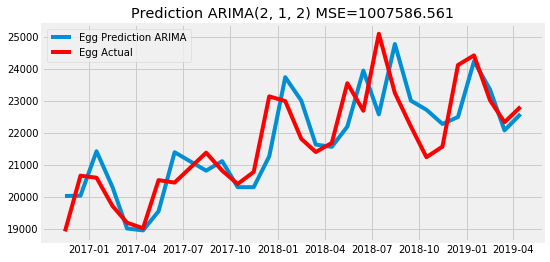

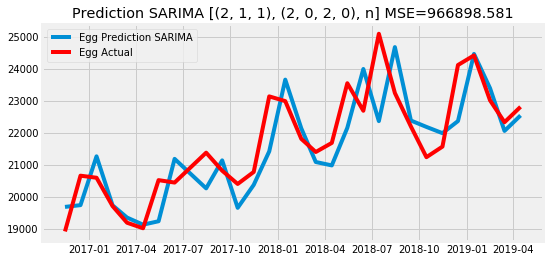

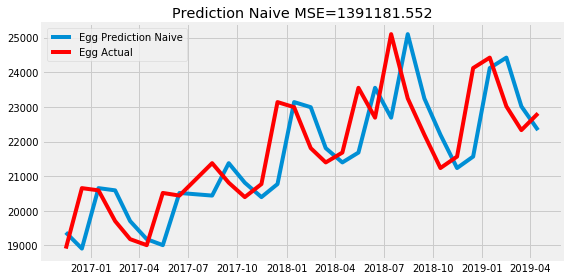

In [52]:
plt.figure(figsize=[8,4])
plt.title('Prediction ARIMA(2, 1, 2) MSE=%.3f' % mse_ARIMA_egg)
plt.plot(predictions_egg_ARIMA_original_value)
plt.plot(test_egg, color='red')
plt.legend(['Egg Prediction ARIMA', 'Egg Actual'])
plt.figure(figsize=[8,4])
plt.title('Prediction SARIMA [(2, 1, 1), (2, 0, 2, 0), n] MSE=%.3f' % mse_SARIMA_egg)
plt.plot(predictions_egg_SARIMA_original_value)
plt.plot(test_egg, color='red')
plt.legend(['Egg Prediction SARIMA', 'Egg Actual'])
plt.figure(figsize=[8,4])
plt.title('Prediction Naive MSE=%.3f' % mse_naive_egg)
plt.plot(pred_egg_naive)
plt.plot(test_egg, color='red')
plt.legend(['Egg Prediction Naive', 'Egg Actual'])
plt.tight_layout()

## Correlation 

In [53]:
dataset_corr = pd.concat([chicken_train, egg_train], axis=1, sort=False)
dataset_corr.columns = ["ChickenPrice", "EggPrice"]
prediction_corr = pd.concat([predictions_chicken_ARIMA_original_value,
                             predictions_egg_SARIMA_original_value,
                            test_chicken, test_egg],
                            axis=1, sort=False)
prediction_corr.columns = ["ChickenPred", "EggPred", "ChickenActual", "EggActual"]

print('chicken dataset: ', len(chicken_train), 'egg dataset: ', len(egg_train))
print('chicken predictions: ', len(predictions_chicken_ARIMA_original_value), 'egg predictions: ', len(predictions_egg_SARIMA_original_value))

chicken dataset:  118 egg dataset:  118
chicken predictions:  29 egg predictions:  29


In [54]:
dataset_corr.corr(method='pearson')

,ChickenPrice,EggPrice
ChickenPrice,1.000000,0.920913
EggPrice,0.920913,1.000000


In [55]:
prediction_corr.corr(method='pearson')

,ChickenPred,EggPred,ChickenActual,EggActual
ChickenPred,1.000000,0.880603,0.932094,0.807627
EggPred,0.880603,1.000000,0.877754,0.811835
ChickenActual,0.932094,0.877754,1.000000,0.895856
EggActual,0.807627,0.811835,0.895856,1.000000


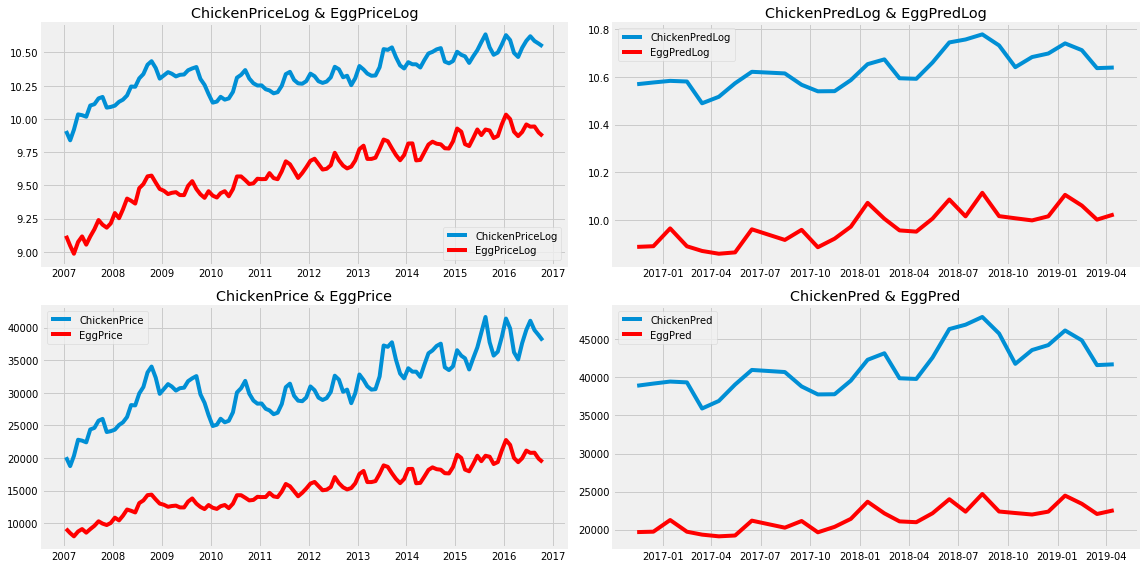

In [56]:
plt.figure(figsize=[16,8])
plt.subplot(221)
plt.title('ChickenPriceLog & EggPriceLog')
plt.plot(train_chicken)
plt.plot(train_egg, color='red')
plt.legend(['ChickenPriceLog', 'EggPriceLog'])
#plt.figure(figsize=[8,4])
plt.subplot(222)
plt.title('ChickenPredLog & EggPredLog')
plt.plot(chicken_ARIMA)
plt.plot(egg_SARIMA, color='red')
plt.legend(['ChickenPredLog', 'EggPredLog'])
#plt.figure(figsize=[8,4])
plt.subplot(223)
plt.title('ChickenPrice & EggPrice')
plt.plot(np.exp(train_chicken))
plt.plot(np.exp(train_egg), color='red')
plt.legend(['ChickenPrice', 'EggPrice'])
#plt.figure(figsize=[8,4])
plt.subplot(224)
plt.title('ChickenPred & EggPred')
plt.plot(predictions_chicken_ARIMA_original_value)
plt.plot(predictions_egg_SARIMA_original_value, color='red')
plt.legend(['ChickenPred', 'EggPred'])
plt.tight_layout()

## Ljung-Box

In [82]:
chicken_ARIMA_decomposed = seasonal_decompose(predictions_chicken_ARIMA_original_value, freq=12)
chicken_ARIMA_residual = chicken_ARIMA_decomposed.resid
import statsmodels.api as sm
sm.stats.acorr_ljungbox(predictions_chicken_ARIMA_original_value, lags=12, boxpierce=True)

#Plot_ACF_PACF(predictions_chicken_ARIMA_original_value)

(array([20.20999527, 28.48590078, 32.51936355, 37.57995091, 45.67859711,
        53.00668023, 55.4993983 , 55.51286698, 56.85484593, 57.90100799,
        58.09094736, 58.63033755]),
 array([6.93894258e-06, 6.52176642e-07, 4.06731887e-07, 1.36792599e-07,
        1.05585773e-08, 1.16966172e-09, 1.18702836e-09, 3.50911027e-09,
        5.38740702e-09, 9.02380353e-09, 2.09340070e-08, 4.00621952e-08]),
 array([18.25418927, 25.46223601, 28.84514027, 32.92625911, 39.19617874,
        44.63314364, 46.40216937, 46.41129332, 47.27708618, 47.91828229,
        48.02856966, 48.32436428]),
 array([1.93300350e-05, 2.95764266e-06, 2.41365444e-06, 1.23673245e-06,
        2.16840334e-07, 5.53520233e-08, 7.29986099e-08, 1.98515060e-07,
        3.48471388e-07, 6.42360200e-07, 1.41102341e-06, 2.74441580e-06]))

## KNN Regressor 

In [56]:
from sklearn.neighbors import KNeighborsRegressor

In [92]:
X_train, X_test, y_train, y_test = egg_train, egg_test, chicken_train, chicken_test
X_train2, X_test2, y_train2, y_test2 = chicken_train, chicken_test, egg_train, egg_test

In [94]:
X_train.head()

,Price
Date,
2007-01-15,9150.7401
2007-02-15,8486.4410
2007-03-15,7993.5490
2007-04-15,8732.9076
2007-05-15,9106.7251


In [59]:
n_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
p_values = [1, 2]
weight_values = ['uniform', 'distance']

print('Chicken')
EvaluateKNNRegressor(n_values, p_values, weight_values, X_train, y_train, X_test, y_test)
print('--------------------------------------------------')
print('Egg')
EvaluateKNNRegressor(n_values, p_values, weight_values, X_train2, y_train2, X_test2, y_test2)

Chicken
n: 2 p: 1 weight: uniform mse: 9508220.77586207
n: 2 p: 1 weight: distance mse: 9508220.77586207
n: 2 p: 2 weight: uniform mse: 9508220.77586207
n: 2 p: 2 weight: distance mse: 9508220.77586207
n: 3 p: 1 weight: uniform mse: 10677060.40613027
n: 3 p: 1 weight: distance mse: 10677060.40613027
n: 3 p: 2 weight: uniform mse: 10677060.40613027
n: 3 p: 2 weight: distance mse: 10677060.40613027
n: 4 p: 1 weight: uniform mse: 10635048.254310345
n: 4 p: 1 weight: distance mse: 10635048.254310345
n: 4 p: 2 weight: uniform mse: 10635048.254310345
n: 4 p: 2 weight: distance mse: 10635048.254310345
n: 5 p: 1 weight: uniform mse: 10709401.139310343
n: 5 p: 1 weight: distance mse: 10709401.139310343
n: 5 p: 2 weight: uniform mse: 10709401.139310343
n: 5 p: 2 weight: distance mse: 10709401.139310343
n: 6 p: 1 weight: uniform mse: 10039142.583333327
n: 6 p: 1 weight: distance mse: 10039142.583333327
n: 6 p: 2 weight: uniform mse: 10039142.583333327
n: 6 p: 2 weight: distance mse: 10039142.5833

In [61]:
# Chicken Prediction
KNN = KNeighborsRegressor(n_neighbors=2, p=1, weights='uniform')
KNN.fit(X_train, y_train)
chicken_pred_KNN = KNN.predict(X_test)

# Egg Prediction
KNN2 = KNeighborsRegressor(n_neighbors=2, p=1, weights='uniform')
KNN2.fit(X_train2, y_train2)
egg_pred_KNN = KNN2.predict(X_test2)

In [62]:
egg_KNN = list()
chicken_KNN = list()
for j in range(0, len(egg_pred_KNN)):
    egg_KNN.append(egg_pred_KNN[j][0])
    chicken_KNN.append(chicken_pred_KNN[j][0])

chicken_KNN_df = MakeDataFrame(chicken_KNN, ['ChickenPredKNN'])
egg_KNN_df = MakeDataFrame(egg_KNN, ['EggPredKNN'])

In [63]:
print('Chicken KNN')
for i in range(len(X_test)):
    print('predicted:', chicken_pred_KNN[i][0], 'expected: ', y_test.iloc[i][0], 'error:', abs(chicken_pred_KNN[i][0]-y_test.iloc[i][0]))

mse_chicken_KNN = mean_squared_error(y_test, chicken_pred_KNN)
mae_chicken_KNN = mean_absolute_error(y_test, chicken_pred_KNN)
mape_chicken_KNN = MAPE(chicken_KNN_df, y_test)
print('MSE chicken KNN: ', mse_chicken_KNN)
print('MAE chicken KNN: ', mae_chicken_KNN)
print('MAPE chicken KNN: ', mape_chicken_KNN)
    
print('---------------------------------------------------')    

print('Egg KNN')
for i in range(len(X_test2)):
    print('predicted:', egg_pred_KNN[i][0], 'expected:', y_test2.iloc[i][0], 'error:', abs(egg_pred_KNN[i][0]-y_test2.iloc[i][0]))    


    
mse_egg_KNN = mean_squared_error(y_test2, egg_pred_KNN)
mae_egg_KNN = mean_absolute_error(y_test2, egg_pred_KNN)
mape_egg_KNN = MAPE(egg_KNN_df, y_test2)
print('MSE egg KNN: ', mse_egg_KNN)
print('MAE egg KNN: ', mae_egg_KNN)
print('MAPE egg KNN: ', mape_egg_KNN)


Chicken KNN
predicted: 36261.5 expected:  37547.0 error: 1285.5
predicted: 38774.5 expected:  38538.0 error: 236.5
predicted: 38774.5 expected:  39906.0 error: 1131.5
predicted: 39030.5 expected:  37480.0 error: 1550.5
predicted: 35486.0 expected:  37285.0 error: 1799.0
predicted: 35486.0 expected:  37777.0 error: 2291.0
predicted: 36729.5 expected:  39133.0 error: 2403.5
predicted: 36729.5 expected:  40123.0 error: 3393.5
predicted: 39092.5 expected:  39868.0 error: 775.5
predicted: 40320.0 expected:  39031.0 error: 1289.0
predicted: 39280.0 expected:  37856.0 error: 1424.0
predicted: 40320.0 expected:  38132.0 error: 2188.0
predicted: 40617.0 expected:  40454.0 error: 163.0
predicted: 40617.0 expected:  42687.0 error: 2070.0
predicted: 39206.0 expected:  41274.0 error: 2068.0
predicted: 39092.5 expected:  40931.0 error: 1838.5
predicted: 39206.0 expected:  41922.0 error: 2716.0
predicted: 40617.0 expected:  44161.0 error: 3544.0
predicted: 40617.0 expected:  45433.0 error: 4816.0
pre

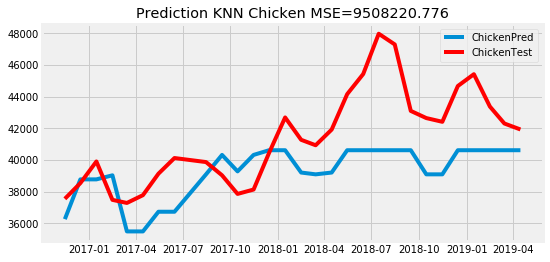

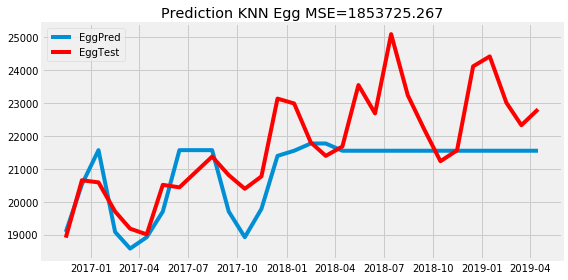

In [64]:
chicken_KNN_df = MakeDataFrame(chicken_KNN, ['Price'])
chicken_index = chicken_test.index
chicken_KNN_df = chicken_KNN_df.set_index(chicken_index)

egg_KNN_df = MakeDataFrame(egg_KNN, ['Price'])
egg_index = egg_test.index
egg_KNN_df = egg_KNN_df.set_index(egg_index)

plt.figure(figsize=[8,4])
plt.title('Prediction KNN Chicken MSE=%.3f' % mse_chicken_KNN)
plt.plot(chicken_KNN_df)
plt.plot(chicken_test, color='red')
plt.legend(['ChickenPred' , 'ChickenTest'])
plt.figure(figsize=[8,4])
plt.title('Prediction KNN Egg MSE=%.3f' % mse_egg_KNN)
plt.plot(egg_KNN_df)
plt.plot(egg_test, color='red')
plt.legend(['EggPred' , 'EggTest'])
plt.tight_layout()

## LSTM

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# univariate data preparation
from numpy import array 

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence.values[i:end_ix], sequence.values[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
chicken_train2, chicken_test2 = train_test_builder(X_chicken_full, size_test=0.2)
print('train: ', len(chicken_train2),',', 'test: ', len(chicken_test2))
chicken_train2.head(10)

In [ ]:
X_train, y_train = split_sequence(chicken_train2, 5)
print('X_train: ', len(X_train),', ', 'y_train: ', len(y_train))
print(X_train.shape)
for i in range(len(X_train)):
    print(X_train[i], y_train[i])
    
X_test, y_test = split_sequence(chicken_test2, 5)
print('X_test: ', len(X_test),', ', 'y_test: ', len(y_test))
print(X_test.shape)
for i in range(len(X_test)):
    print(X_test[i], y_test[i])

## Model 

In [ ]:
n_features = X_train.shape[2]
n_steps = X_train.shape[1]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ["mae"])
#model.compile(loss='mse', optimizer= SGD(lr=0.01, nesterov=True), metrics = ["mae"])

In [ ]:
# fit model
model.fit(X_train, y_train, epochs=300, verbose=1)

In [ ]:
# demonstrate prediction
x_input = array([X_test[0][x] for x in range(len(X_test[0]))])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0) 
print(yhat)
print(y_test[0])
len(X_test)

In [ ]:
def PredictLSTM(input):
    prediction = list()
    for i in range(len(input)):
        X_input = array([input[i][x] for x in range(len(input[i]))])
        X_input = X_input.reshape((1, n_steps, n_features))
        yhat = model.predict(X_input, verbose=0)
        prediction.append(yhat)
    return prediction

In [ ]:
pred_LSTM = PredictLSTM(X_test)
#pred_LSTM

prediction_LSTM = list()
for i in range(len(pred_LSTM)):
    prediction_LSTM.append(pred_LSTM[i][0][0])

for i in range(len(y_test)):
    print('predicted: ', prediction_LSTM[i], ', ', 'expected: ', y_test[i][0], ', error: ', abs(prediction_LSTM[i]-y_test[i][0]))

# MAPE
temp = list()
for t in range(len(prediction_LSTM)):
    var = abs((y_test[t][0]-prediction_LSTM[t])/y_test[t][0])
    temp.append(var)
           
mape_LSTM = 100*(1/len(prediction_LSTM)*sum(temp))

    
mse_LSTM = mean_squared_error(y_test, prediction_LSTM)
mae_LSTM = mean_absolute_error(y_test, prediction_LSTM)
print('MSE: ', mse_LSTM)
print('MAE: ', mae_LSTM)
print('MAPE: ', mape_LSTM)

# Data Harian (PHPN)

In [ ]:
data_harian = pd.read_excel('data_harian/PriceDataset.xlsx')
data_harian['Tanggal'] = pd.to_datetime(data_harian['Tanggal'], infer_datetime_format=True)
indexed_data_harian = data_harian.set_index(['Tanggal'])
#data_harian.head(15)
indexed_data_harian.head()

In [ ]:
indexed_data_harian_filled = indexed_data_harian.fillna(method='ffill') # forward fill, fill null dengan value instance sebelumnya
indexed_data_harian_filled = indexed_data_harian_filled.fillna(method='bfill') # backward fill, fill null dengan value instance sesudahnya
indexed_data_harian_filled.head(15)
#data_harian_filled.info()

In [ ]:
len(indexed_data_harian_filled)

In [ ]:
BawangMerah = indexed_data_harian_filled.BawangMerah
BawangMerah = MakeDataFrame(BawangMerah, ['BawangMerah'])
BawangMerah.head(10)

In [ ]:
plt.figure(figsize=[16,12])
plt.subplot(521)
plt.plot(indexed_data_harian_filled.Beras, label='Beras')
plt.legend(loc='best')
plt.subplot(522)
plt.plot(indexed_data_harian_filled.DagingAyam, label='DagingAyam')
plt.legend(loc='best')
plt.subplot(523)
plt.plot(indexed_data_harian_filled.DagingSapi, label='DagingSapi')
plt.legend(loc='best')
plt.subplot(524)
plt.plot(indexed_data_harian_filled.TelurAyam, label='TelurAyam')
plt.legend(loc='best')
plt.subplot(525)
plt.plot(indexed_data_harian_filled.BawangMerah, label='BawangMerah')
plt.legend(loc='best')
plt.subplot(526)
plt.plot(indexed_data_harian_filled.BawangPutih, label='BawangPutih')
plt.legend(loc='best')
plt.subplot(527)
plt.plot(indexed_data_harian_filled.CabaiMerah, label='CabaiMerah')
plt.legend(loc='best')
plt.subplot(528)
plt.plot(indexed_data_harian_filled.CabaiRawit, label='CabaiRawit')
plt.legend(loc='best')
plt.subplot(529)
plt.plot(indexed_data_harian_filled.MinyakGoreng, label='MinyakGoreng')
plt.legend(loc='best')
plt.subplot(529)
plt.plot(indexed_data_harian_filled.GulaPasir, label='GulaPasir')
plt.legend(loc='best')
plt.tight_layout()
print('Plot Price')